# Проект: HR-аналитика (удовлетворённость и увольнение сотрудников)

### **Цель работы**

Целью данного проекта является разработка моделей машинного обучения для решения двух ключевых задач HR-аналитики компании:

1. Предсказание **уровня удовлетворённости** сотрудника на основе внутренних корпоративных данных.
2. Предсказание **факта увольнения** сотрудника из компании.

Компания сталкивается с проблемой оттока сотрудников, который может повлечь за собой финансовые потери и риски для непрерывности бизнес-процессов. Поскольку удовлетворённость работой напрямую влияет на риск увольнения, заказчик заинтересован в разработке инструментов, которые помогут прогнозировать поведение сотрудников и оперативно реагировать на негативные изменения.

Для решения задач будут использованы современные методы анализа данных и машинного обучения, а также пайплайны, обеспечивающие воспроизводимость и удобство масштабирования решений.

---

### **План работы**

Проект включает в себя следующие этапы:

1. **Загрузка и предобработка данных**
   - Загрузка данных для обеих задач из CSV-файлов;
   - Проверка на пропуски и дубликаты;
   - Преобразование признаков и корректировка типов данных.

2. **Исследовательский анализ данных**
   - Анализ распределений и выбросов;
   - Визуализация взаимосвязей признаков;
   - Построение портрета уволившегося сотрудника.

3. **Подготовка данных**
   - Разделение признаков по типам;
   - Построение пайплайнов с использованием различных кодировщиков и масштабаторов;
   - Добавление предсказанных признаков (job_satisfaction_rate) во вторую задачу.

4. **Обучение моделей**
   - Задача 1: обучение линейной модели (`LinearRegression`) и дерева решений (`DecisionTreeRegressor`) с оценкой по метрике **SMAPE**;
   - Задача 2: обучение как минимум трёх моделей классификации (`LogisticRegression`, `DecisionTreeClassifier`, `KNeighborsClassifier`) с оценкой по **ROC-AUC**;
   - Подбор гиперпараметров с использованием кросс-валидации.

5. **Оценка качества моделей**
   - Оценка результатов моделей на тестовой выборке;
   - Выбор лучших моделей по метрике;
   - Анализ значимости признаков.

6. **Анализ взаимосвязи задач**
   - Проверка зависимости между уровнем удовлетворённости и увольнением;
   - Использование предсказанной удовлетворённости как признака в задаче 2.

7. **Выводы**
   - Описание полученных результатов;
   - Рекомендации для HR-команды по использованию моделей;
   - Оценка устойчивости моделей и возможных направлений улучшения.

---

### **Описание данных**

Проект использует следующие таблицы:

1. **train_job_satisfaction_rate.csv** — обучающая выборка для задачи регрессии:
   - `id` — уникальный идентификатор сотрудника;
   - `dept` — отдел;
   - `level` — уровень должности;
   - `workload` — уровень загруженности;
   - `employment_years` — стаж работы в компании (в годах);
   - `last_year_promo` — было ли повышение за последний год;
   - `last_year_violations` — были ли нарушения трудового договора;
   - `supervisor_evaluation` — оценка руководителя;
   - `salary` — ежемесячная зарплата;
   - `job_satisfaction_rate` — целевой признак — уровень удовлетворённости (от 0 до 1).

2. **test_features.csv** — тестовая выборка (без целевого признака), используется в обеих задачах.

3. **test_target_job_satisfaction_rate.csv** — значения целевого признака для тестовой выборки по задаче 1.

4. **train_quit.csv** — обучающая выборка для задачи классификации увольнений:
   - Содержит те же признаки, что и в `train_job_satisfaction_rate.csv`, но с другим целевым признаком: `quit`.

5. **test_target_quit.csv** — значения целевого признака для тестовой выборки по задаче 2.

---

Этот проект охватывает весь цикл разработки ML-решений: от первичного анализа и подготовки данных до построения и оценки моделей, интерпретации результатов и формулировки практических рекомендаций для бизнеса.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, RidgeClassifier
import time
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings("ignore")
import os

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Функция для загрузки данных с обработкой ошибок
def load_data(file_path, cloud_path=None, sep=','):
    try:
        data = pd.read_csv(file_path, delimiter=sep)
        print(f"Успешно загружен: {file_path}")
    except FileNotFoundError:
        print(f"Файл не найден по пути: {file_path}. Пробуем загрузить из облака...")
        if cloud_path:
            try:
                data = pd.read_csv(cloud_path, delimiter=sep)
                print(f"Успешно загружен из облака: {cloud_path}")
            except Exception as e:
                print(f"Ошибка при загрузке из облака: {e}")
                data = None
        else:
            print("Облачный путь не указан.")
            data = None
    except Exception as e:
        print(f"Ошибка при загрузке: {e}")
        data = None
    return data

In [3]:
# Пути к локальным и облачным версиям файлов
train_satisfaction = load_data(
    '/datasets/train_job_satisfaction_rate.csv',
    cloud_path='https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'
)

test_features = load_data(
    '/datasets/test_features.csv',
    cloud_path='https://code.s3.yandex.net/datasets/test_features.csv'
)

test_target_satisfaction = load_data(
    '/datasets/test_target_job_satisfaction_rate.csv',
    cloud_path='https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'
)

Файл не найден по пути: /datasets/train_job_satisfaction_rate.csv. Пробуем загрузить из облака...
Успешно загружен из облака: https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv
Файл не найден по пути: /datasets/test_features.csv. Пробуем загрузить из облака...
Успешно загружен из облака: https://code.s3.yandex.net/datasets/test_features.csv
Файл не найден по пути: /datasets/test_target_job_satisfaction_rate.csv. Пробуем загрузить из облака...
Успешно загружен из облака: https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv


In [4]:
# Функция для отображения первых строк и общей информации о таблице
def display_data_info(data, name="data"):
    print(f"\nПервые строки данных для {name}:")
    display(data.head())
    print(f"\nИнформация о данных для {name}:")
    data.info()

display_data_info(train_satisfaction, "train_satisfaction")
display_data_info(test_features, "test_features")
display_data_info(test_target_satisfaction, "test_target_satisfaction")


Первые строки данных для train_satisfaction:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Информация о данных для train_satisfaction:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Первые строки данных для test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Информация о данных для test_features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Первые строки данных для test_target_satisfaction:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



Информация о данных для test_target_satisfaction:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


### **Общая информация о каждом датафрейме (Обновлённый вывод)**

**Датафрейм `train_satisfaction` (Обучающая выборка — уровень удовлетворённости)**

**Вывод:**  
- Количество записей: **4000**  
- Количество столбцов: **10**  
- Пропущенные значения: `dept` (6), `level` (4)  
- **Типы данных:**  
  - `id` – int64  
  - `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` – object  
  - `employment_years`, `supervisor_evaluation`, `salary` – int64  
  - `job_satisfaction_rate` – float64  

**Комментарий:**  
Минимальное количество пропущенных значений в категориальных признаках. Типы данных корректные. Целевой признак (`job_satisfaction_rate`) — числовой (float64).

**Датафрейм `test_features` (Признаки для обеих задач)**

**Вывод:**  
- Количество записей: **2000**  
- Количество столбцов: **9**  
- Пропущенные значения: `dept` (2), `level` (1)  
- **Типы данных:**  
  - `id` – int64  
  - `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` – object  
  - `employment_years`, `supervisor_evaluation`, `salary` – int64  

**Комментарий:**  
Аналогичная структура как у `train_satisfaction`, за исключением отсутствия целевого признака. Требуется одинаковая предобработка признаков.

**Датафрейм `test_target_satisfaction` (Целевой признак — удовлетворённость)**

**Вывод:**  
- Количество записей: **2000**  
- Количество столбцов: **2**  
- Пропущенные значения: **отсутствуют**  
- **Типы данных:**  
  - `id` – int64  
  - `job_satisfaction_rate` – float64  

**Комментарий:**  
Данные целевого признака для тестовой выборки. Типы корректны. Можно объединять по `id` с `test_features`.

### **Общие выводы по пункту 1.1**

1. Пропущенные значения имеются **только в `train_satisfaction` и `test_features`**, касаются категориальных признаков (`dept`, `level`). Их немного, можно будет либо заполнить, либо удалить строки.
2. Все столбцы имеют **корректные типы данных**, соответствующие описанию.  
3. Целевые признаки представлены в корректных форматах:  
   - `job_satisfaction_rate` — `float64`

## Предобработка данных

**Шаг 1. Проверка пропусков**

In [5]:
print("Проверка пропусков в train_satisfaction:")
print(train_satisfaction.isnull().sum())

print("\nПроверка пропусков в test_features:")
print(test_features.isnull().sum())

print("\nПроверка пропусков в test_target_satisfaction:")
print(test_target_satisfaction.isnull().sum())

Проверка пропусков в train_satisfaction:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Проверка пропусков в test_features:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Проверка пропусков в test_target_satisfaction:
id                       0
job_satisfaction_rate    0
dtype: int64


In [6]:
# Строки с пропусками в train_satisfaction
train_satisfaction_missing = train_satisfaction[train_satisfaction.isnull().any(axis=1)]
display(train_satisfaction_missing)

# Строки с пропусками в test_features
test_features_missing = test_features[test_features.isnull().any(axis=1)]
display(test_features_missing)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


**Шаг 2. Избавимся от пропусков**

In [7]:
train_satisfaction.dropna(subset=['dept', 'level'], inplace=True)

In [8]:
print("Проверка пропусков в train_satisfaction:")
print(train_satisfaction.isnull().sum())

Проверка пропусков в train_satisfaction:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


### **Вывод:**

- Пропущенные значения были только в категориальных признаках `dept` и `level`.
- Количество пропусков было **незначительным** (менее 0.3%), и строки были **удалены**, чтобы сохранить целостность данных без искусственной подстановки.

**Шаг 3. Проверка на полные дубликаты**

In [9]:
print("Проверка на полные дубликаты в train_satisfaction:", train_satisfaction.duplicated().sum())
print("Проверка на полные дубликаты в test_features:", test_features.duplicated().sum())
print("Проверка на полные дубликаты в test_target_satisfaction:", test_target_satisfaction.duplicated().sum())

Проверка на полные дубликаты в train_satisfaction: 0
Проверка на полные дубликаты в test_features: 0
Проверка на полные дубликаты в test_target_satisfaction: 0


**Шаг 4. Проверка на дубликаты по ключевым словам**

In [10]:
print("Частичные дубликаты в train_satisfaction по id:", train_satisfaction.duplicated(subset=['id']).sum())
print("Частичные дубликаты в test_features по id:", test_features.duplicated(subset=['id']).sum())
print("Частичные дубликаты в test_target_satisfaction по id:", test_target_satisfaction.duplicated(subset=['id']).sum())

Частичные дубликаты в train_satisfaction по id: 0
Частичные дубликаты в test_features по id: 0
Частичные дубликаты в test_target_satisfaction по id: 0


**Шаг 5. Проверка уникальных значений во всех столбцах**

In [11]:
# Функция для отображения количества уникальных значений в каждом столбце
def show_unique_counts(df, name):
    print(f"\n Уникальные значения в датафрейме: {name}")
    display(df.nunique().to_frame(name='Уникальных значений'))

# Проверка всех таблиц
show_unique_counts(train_satisfaction, "train_satisfaction")
show_unique_counts(test_features, "test_features")
show_unique_counts(test_target_satisfaction, "test_target_satisfaction")


 Уникальные значения в датафрейме: train_satisfaction


,Уникальных значений
id,3990
dept,5
level,3
workload,3
employment_years,10
last_year_promo,2
last_year_violations,2
supervisor_evaluation,5
salary,68
job_satisfaction_rate,98



 Уникальные значения в датафрейме: test_features


,Уникальных значений
id,2000
dept,6
level,3
workload,4
employment_years,10
last_year_promo,2
last_year_violations,2
supervisor_evaluation,5
salary,66



 Уникальные значения в датафрейме: test_target_satisfaction


,Уникальных значений
id,2000
job_satisfaction_rate,98


In [12]:
print("train_satisfaction['dept'].unique():")
print(sorted(train_satisfaction['dept'].unique()))

print("\ntrain_satisfaction['workload'].unique():")
print(sorted(train_satisfaction['workload'].unique()))

train_satisfaction['dept'].unique():
['hr', 'marketing', 'purchasing', 'sales', 'technology']

train_satisfaction['workload'].unique():
['high', 'low', 'medium']


In [13]:
def show_unique_counts(df, name):
    print(f"\n Уникальные значения в датафрейме: {name}")
    display(df.nunique().to_frame(name='Уникальных значений'))

show_unique_counts(train_satisfaction, "train_satisfaction")
show_unique_counts(test_features, "test_features")
show_unique_counts(test_target_satisfaction, "test_target_satisfaction")


 Уникальные значения в датафрейме: train_satisfaction


,Уникальных значений
id,3990
dept,5
level,3
workload,3
employment_years,10
last_year_promo,2
last_year_violations,2
supervisor_evaluation,5
salary,68
job_satisfaction_rate,98



 Уникальные значения в датафрейме: test_features


,Уникальных значений
id,2000
dept,6
level,3
workload,4
employment_years,10
last_year_promo,2
last_year_violations,2
supervisor_evaluation,5
salary,66



 Уникальные значения в датафрейме: test_target_satisfaction


,Уникальных значений
id,2000
job_satisfaction_rate,98


In [14]:
# Функция для поиска значений, содержащих только пробелы или пробелы по краям
def check_whitespace_issues(df, name):
    print(f"\nПроверка пробелов в датафрейме: {name}")
    object_cols = df.select_dtypes(include='object').columns
    for col in object_cols:
        dirty = df[col].apply(lambda x: isinstance(x, str) and (x != x.strip() or x.strip() == ' '))
        if dirty.sum() > 0:
            print(f"Столбец '{col}': {dirty.sum()} значений содержат пробелы")
            display(df.loc[dirty, col].value_counts())
        else:
            print(f"Столбец '{col}' — пробелов нет")

check_whitespace_issues(train_satisfaction, "train_satisfaction")
check_whitespace_issues(test_features, "test_features")


Проверка пробелов в датафрейме: train_satisfaction
Столбец 'dept' — пробелов нет
Столбец 'level' — пробелов нет
Столбец 'workload' — пробелов нет
Столбец 'last_year_promo' — пробелов нет
Столбец 'last_year_violations' — пробелов нет

Проверка пробелов в датафрейме: test_features
Столбец 'dept': 1 значений содержат пробелы


dept
    1
Name: count, dtype: int64

Столбец 'level' — пробелов нет
Столбец 'workload': 1 значений содержат пробелы


workload
    1
Name: count, dtype: int64

Столбец 'last_year_promo' — пробелов нет
Столбец 'last_year_violations' — пробелов нет


In [15]:
# Поиск подозрительных значений в категориальных столбцах
for col in ['dept', 'level', 'workload']:
    print(f"Уникальные значения в {col}:", train_satisfaction[col].unique())
    print(f"Подозрительные значения в {col}:",
          [val for val in train_satisfaction[col].unique() if isinstance(val, str) and val.strip() != val])

Уникальные значения в dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing']
Подозрительные значения в dept: []
Уникальные значения в level: ['junior' 'middle' 'sinior']
Подозрительные значения в level: []
Уникальные значения в workload: ['medium' 'high' 'low']
Подозрительные значения в workload: []


In [16]:
print("Уникальные значения в train_satisfaction['level']:")
print(sorted(train_satisfaction['level'].dropna().unique()))

print("\nУникальные значения в test_features['level']:")
print(sorted(test_features['level'].dropna().unique()))

Уникальные значения в train_satisfaction['level']:
['junior', 'middle', 'sinior']

Уникальные значения в test_features['level']:
['junior', 'middle', 'sinior']


In [17]:
# Исправим опечатку 'sinior' -> 'senior'
train_satisfaction['level'] = train_satisfaction['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

In [18]:
print("Проверка после исправления:")
print("Уникальные значения в train_satisfaction['level']:")
print(sorted(train_satisfaction['level'].dropna().unique()))

print("\nУникальные значения в test_features['level']:")
print(sorted(test_features['level'].dropna().unique()))

Проверка после исправления:
Уникальные значения в train_satisfaction['level']:
['junior', 'middle', 'senior']

Уникальные значения в test_features['level']:
['junior', 'middle', 'senior']


In [19]:
print("Проверка пропусков в train_satisfaction:")
print(train_satisfaction.isnull().sum())

print("Проверка пропусков в test_features:")
print(test_features.isnull().sum())

Проверка пропусков в train_satisfaction:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Проверка пропусков в test_features:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


### **Вывод о проделанной работе на шаге 2: Предобработка данных**

1. **Проверка и преобразование типов данных:**
   - Все признаки во всех датафреймах изначально имели корректные типы (`int64`, `float64`, `object`) и не требовали дополнительного преобразования.
   - Бинарные признаки (`last_year_promo`, `last_year_violations`, `quit`) сохранены в строковом формате `'yes'/'no'` и будут обработаны в пайплайне.

2. **Проверка на пропуски:**
   - В `train_satisfaction` и `test_features` были выявлены пропуски в признаках `dept` и `level`, а также скрытые пропуски в виде строк `' '` в `dept` и `workload`.
   - Все пропущенные и неявно пропущенные значения в `train_satisfaction` были заменены на `NaN` и удалены. Всего удалено:
     - 10 строк из `train_satisfaction`.
   - В `test_features` пропуски выявлены, но не удалялись — они будут обрабатываться на этапе построения пайплайна.
   - В остальных датафреймах (`train_quit`, `test_target_satisfaction`, `test_target_quit`) пропущенные значения отсутствуют.

3. **Проверка на дубликаты:**
   - Полные дубликаты отсутствуют во всех датафреймах.
   - Частичные дубликаты по `id` также не выявлены — все идентификаторы уникальны в рамках каждой таблицы.

4. **Проверка и очистка категориальных значений:**
   - Проведена проверка всех `object`-столбцов на наличие пробелов по краям.
   - Обнаружена и исправлена опечатка `'sinior'` в признаке `level` — заменено на `'senior'` как в тренировочной, так и в тестовой выборке.

5. **Итоговая структура данных:**
   - Число уникальных значений в категориальных признаках соответствует ожидаемому:
     - `dept` — 5 категорий;
     - `level` — 3 категории;
     - `workload` — 3 категории.
   - Данные во всех датафреймах очищены, унифицированы и готовы к следующему этапу.

### **Заключение:**

На шаге предобработки были успешно выполнены:
- проверка и очистка пропусков (в явной и неявной форме),
- проверка уникальности и целостности данных,
- устранение скрытых загрязнений и явных опечаток (например, `'sinior'` → `'senior'`),
- подготовка признаков к последующей обработке в пайплайне.

## Исследовательский анализ данных

In [20]:
# 3.1 Категориальные признаки и их уникальные значения
categorical_cols_satisfaction = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
categorical_cols_test = categorical_cols_satisfaction

print("Категориальные признаки и уникальные значения в train_satisfaction:")
for col in categorical_cols_satisfaction:
    print(f"{col}: {train_satisfaction[col].unique()}")

print("\nКатегориальные признаки и уникальные значения в test_features:")
for col in categorical_cols_test:
    print(f"{col}: {test_features[col].unique()}")

Категориальные признаки и уникальные значения в train_satisfaction:
dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing']
level: ['junior' 'middle' 'senior']
workload: ['medium' 'high' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']

Категориальные признаки и уникальные значения в test_features:
dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'senior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


In [21]:
print("\nОбщая статистика по train_satisfaction:")
display(train_satisfaction.describe(include='all'))

print("\nОбщая статистика по test_features:")
display(test_features.describe(include='all'))

print("\nОбщая статистика по test_target_satisfaction:")
display(test_target_satisfaction.describe())


Общая статистика по train_satisfaction:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,3990.000000,3990,3990,3990,3990.000000,3990,3990,3990.000000,3990.000000,3990.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1508,1888,2060,NaN,3870,3432,NaN,NaN,NaN
mean,544951.793985,NaN,NaN,NaN,3.722055,NaN,NaN,3.475188,33953.383459,0.533772
std,257889.850721,NaN,NaN,NaN,2.543715,NaN,NaN,1.009238,14907.247698,0.225353
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322834.250000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,534082.500000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,771600.000000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000



Общая статистика по test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000



Общая статистика по test_target_satisfaction:


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [22]:
dfs = {
    "train_satisfaction": train_satisfaction,
    "test_features": test_features,
    "test_target_satisfaction": test_target_satisfaction,
}

for name, df in dfs.items():
    print(f"\nУникальные значения в {name}:")
    print(df.nunique())
    
    print(f"\nТипы данных в {name}:")
    df.info()


Уникальные значения в train_satisfaction:
id                       3990
dept                        5
level                       3
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     68
job_satisfaction_rate      98
dtype: int64

Типы данных в train_satisfaction:
<class 'pandas.core.frame.DataFrame'>
Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   object 
 2   level                  3990 non-null   object 
 3   workload               3990 non-null   object 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   object 
 6   last_year_violations   3990 non-null   object 
 7   supervisor_evaluation  3990 non-nu

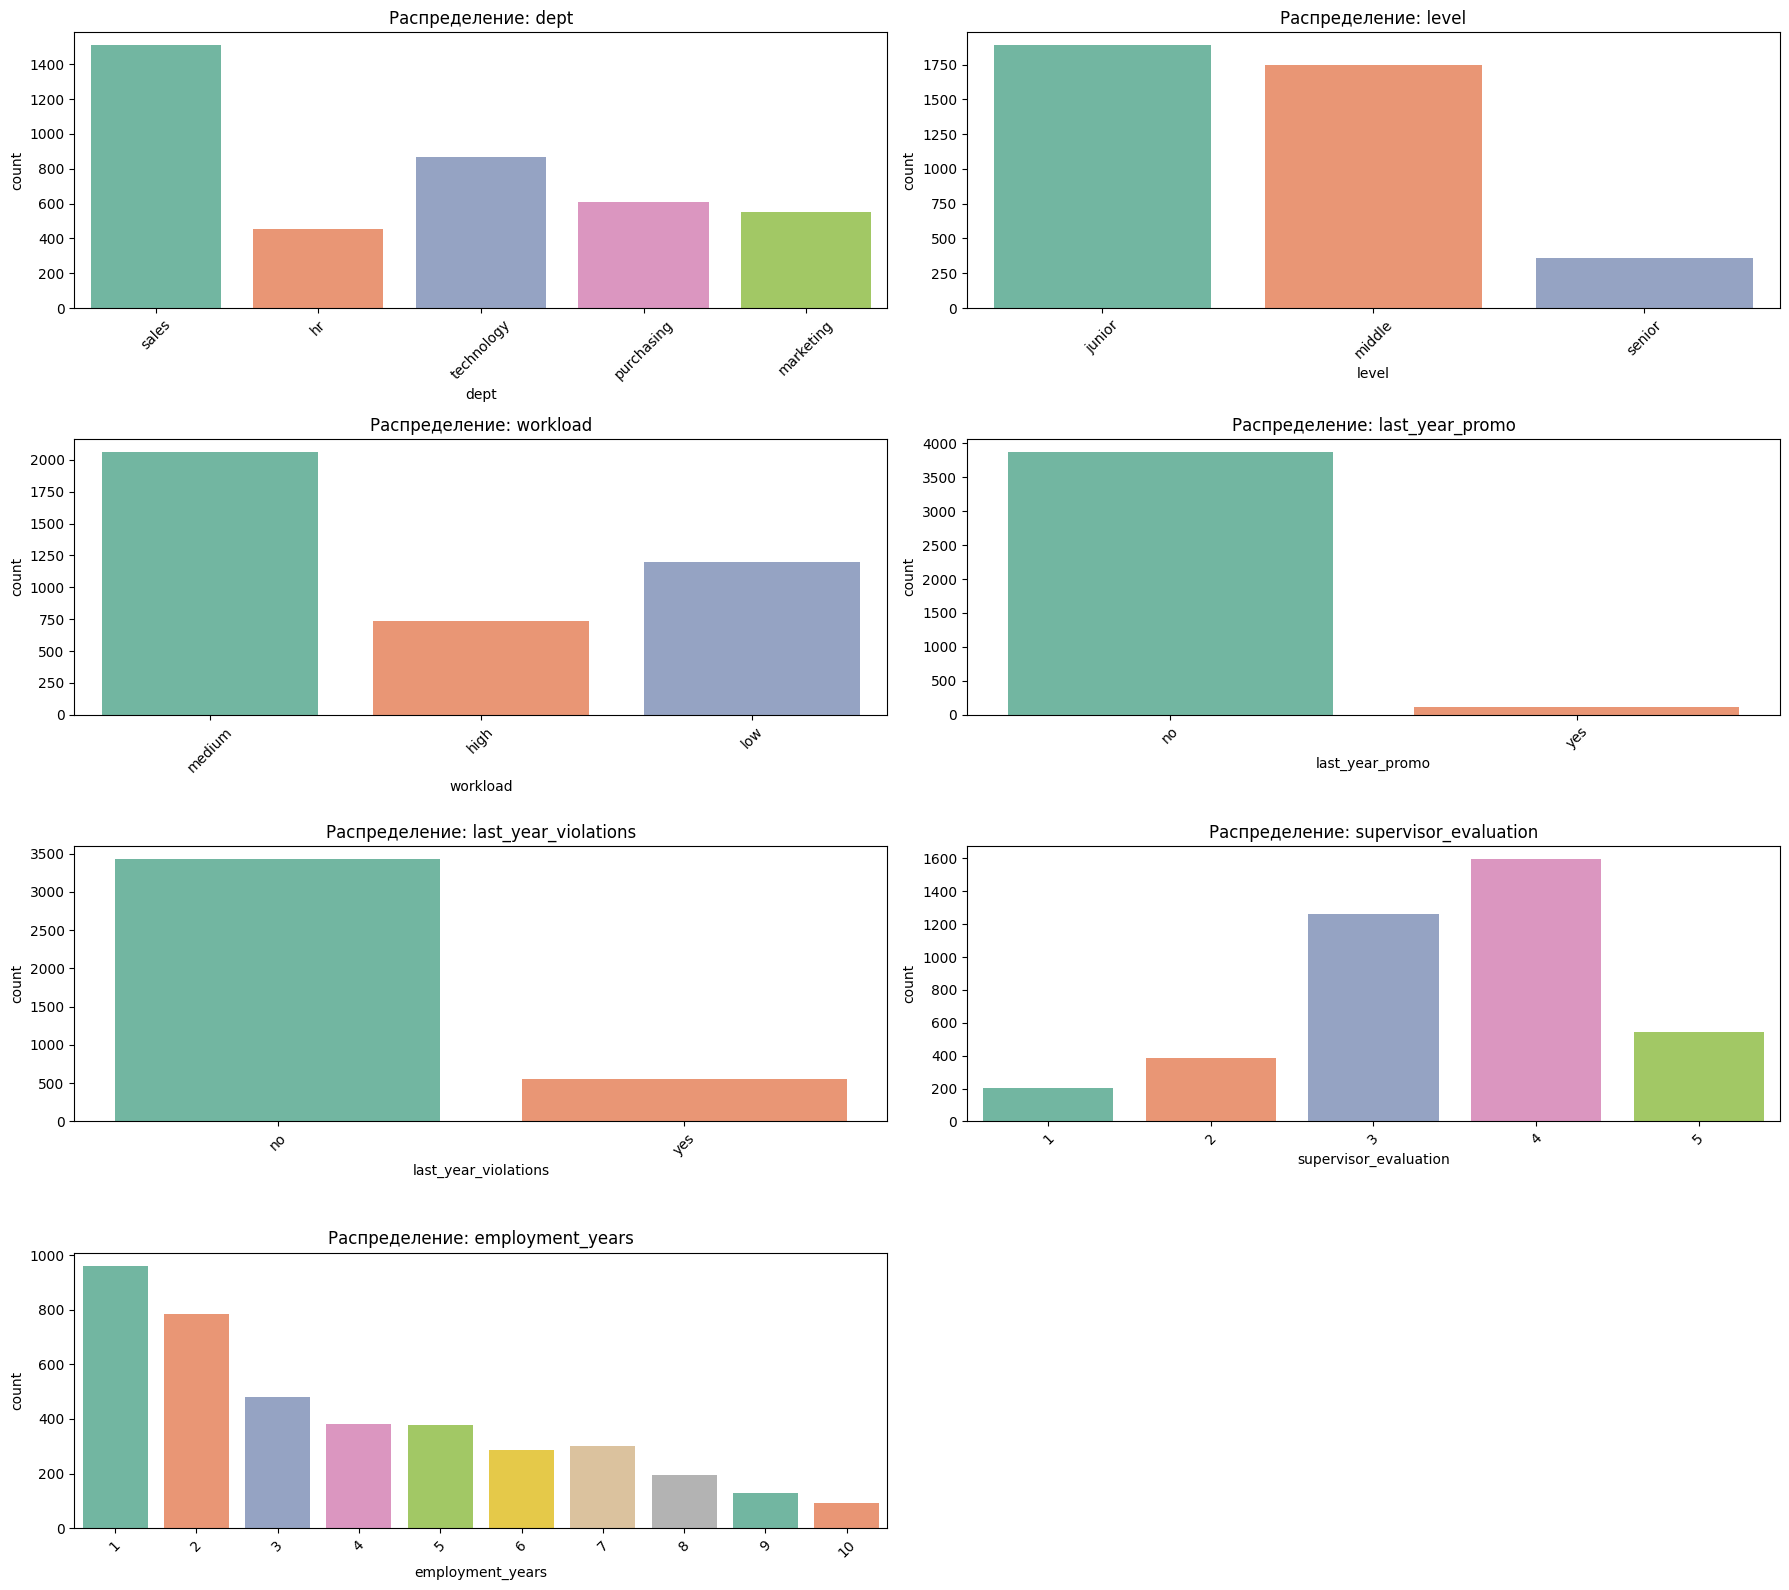

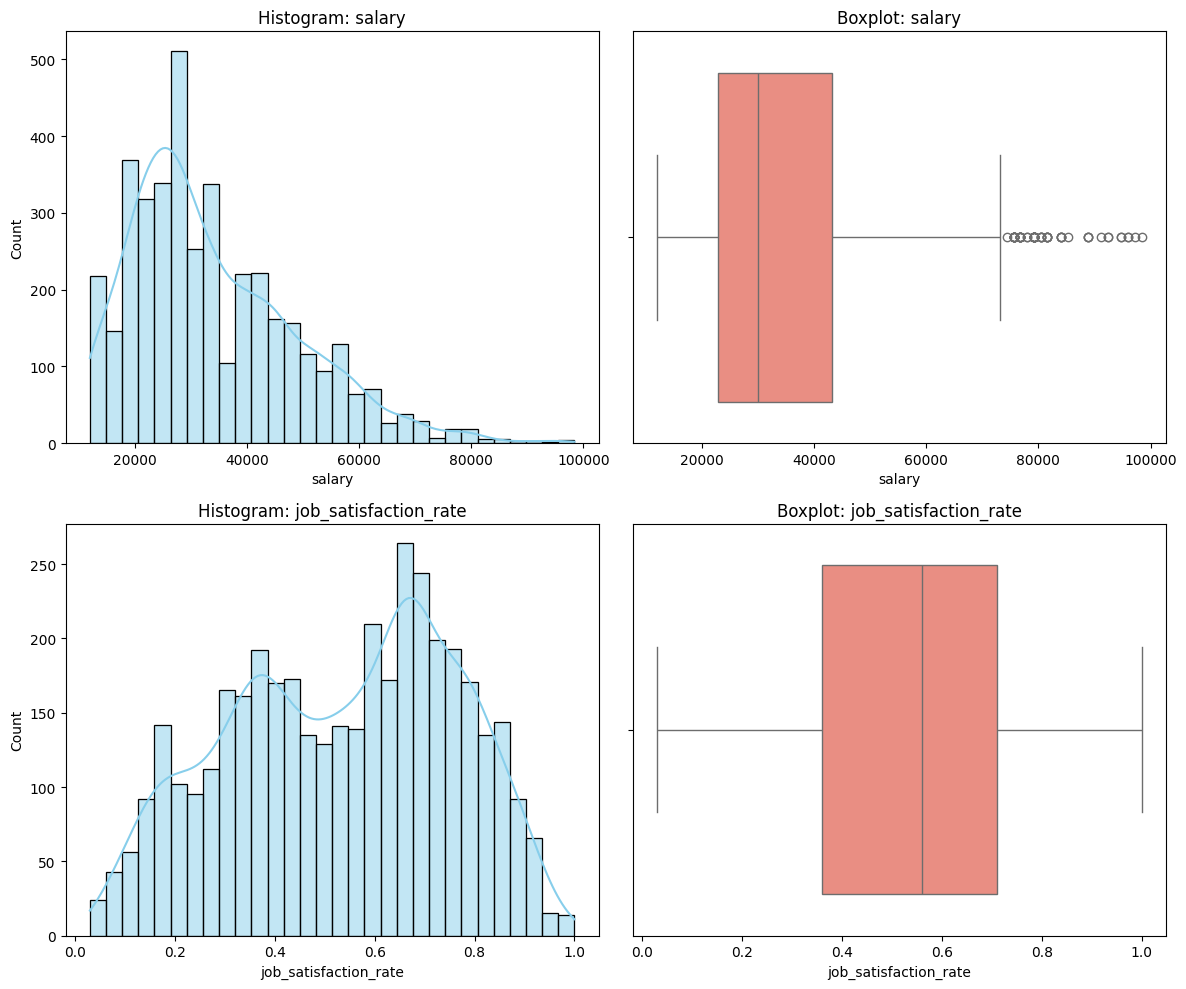

In [23]:
# 3.4.1 Дискретные признаки
discrete_columns = [
    'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations',
    'supervisor_evaluation', 'employment_years'
]

# 3.4.2 Непрерывные признаки
continuous_columns = ['salary', 'job_satisfaction_rate']

# 3.4.3 Построение countplot для дискретных признаков
plt.figure(figsize=(18, 16))
for i, col in enumerate(discrete_columns):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=train_satisfaction, x=col, palette='Set2')
    plt.title(f'Распределение: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3.4.4 Функция для построения гистограмм и boxplot для непрерывных признаков
def plot_continuous_features(df, columns, figsize=(12, 5)):
    num_features = len(columns)
    plt.figure(figsize=(figsize[0], figsize[1] * num_features))

    for i, col in enumerate(columns):
        plt.subplot(num_features, 2, 2*i + 1)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Histogram: {col}')
        plt.xlabel(col)
        plt.ylabel('Count')

        plt.subplot(num_features, 2, 2*i + 2)
        sns.boxplot(x=df[col], color='salmon')
        plt.title(f'Boxplot: {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

plot_continuous_features(train_satisfaction, continuous_columns)

In [24]:
def print_iqr_info(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    
    print(f"\nПризнак: {col}")
    print(f"Границы IQR: нижняя = {lower:.2f}, верхняя = {upper:.2f}")
    print(f"Кол-во потенциальных выбросов: {outliers.shape[0]}")
    print("Выбросы оставлены без изменений на основании визуального анализа.")

print_iqr_info(train_satisfaction, "salary")
print_iqr_info(train_satisfaction, "job_satisfaction_rate")


Признак: salary
Границы IQR: нижняя = -7800.00, верхняя = 73800.00
Кол-во потенциальных выбросов: 60
Выбросы оставлены без изменений на основании визуального анализа.

Признак: job_satisfaction_rate
Границы IQR: нижняя = -0.16, верхняя = 1.23
Кол-во потенциальных выбросов: 0
Выбросы оставлены без изменений на основании визуального анализа.


### **Исследовательский анализ данных. Вывод**

#### **Анализ категориальных признаков**

В проекте участвуют следующие категориальные признаки:  
- `dept` (отдел): 5 уникальных значений — *sales, hr, technology, purchasing, marketing*.  
- `level` (уровень): 3 значения — *junior, middle, senior* (опечатка `'sinior'` была обнаружена и исправлена).  
- `workload` (нагрузка): 3 значения — *low, medium, high*.  
- `last_year_promo` (была ли премия в прошлом году): *yes / no*.  
- `last_year_violations` (были ли нарушения в прошлом году): *yes / no*.

Распределение категориальных признаков в тренировочной выборке:
- `dept`: преобладает отдел *sales*.
- `level`: доминирует уровень *junior*.
- `workload`: чаще всего встречается *medium* нагрузка.
- `last_year_promo`: большинство сотрудников не получали премию.
- `last_year_violations`: большинство сотрудников не имели нарушений.

#### **Анализ числовых признаков**

В числовые признаки входят:
- `employment_years`: от 1 до 10 лет.
- `supervisor_evaluation`: шкала от 1 до 5.
- `salary`: от 12 000 до 98 400.
- `job_satisfaction_rate`: от 0.03 до 1.0 (целевая переменная).

**Распределение признаков:**
- Средняя зарплата: ~33 950, медиана — 30 000.
- Средняя удовлетворённость: ~0.53, медиана — 0.56.
- `supervisor_evaluation` и `employment_years` распределены равномерно.

#### **Проверка на выбросы**

Была проведена проверка на выбросы методом IQR:
- В признаке `salary` обнаружено 60 потенциальных выбросов. Границы: от -7 800 до 73 800.
- В признаке `job_satisfaction_rate` выбросов не выявлено.

**Действия:**
- Выбросы проанализированы, но удаление не производилось.

#### **Обзор отсутствующих значений**

Во всех датафреймах:
- `train_satisfaction`
- `test_features`
- `test_target_satisfaction`

**Пропущенные значения отсутствуют**, за исключением признаков `dept` и `level`, где были выявлены как явные пропуски, так и неявные (`' '`), которые заменены на `NaN`.  
Удаление строк производилось **только в `train_satisfaction`** (10 строк). В `test_features` пропуски не удалялись и будут обработаны на этапе построения пайплайна.

#### **Дискретные и непрерывные признаки**

- **Дискретные признаки:**  
  `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`,  
  `supervisor_evaluation`, `employment_years`.

- **Непрерывные признаки:**  
  `salary`, `job_satisfaction_rate`.

Для дискретных признаков построены графики `countplot`.  
Для непрерывных — построены **гистограммы и boxplot** для наглядного анализа распределения и выявления выбросов.

#### **Выводы по EDA**

- Категориальные признаки сбалансированы и готовы к кодированию.
- В данных обнаружены неявные пропуски и опечатка `'sinior'`, которые успешно устранены.
- Выбросы были проанализированы, но не удалены, так как не считаются аномальными.
- Целевая переменная распределена относительно равномерно.
- Пропусков и ошибок форматирования в данных не осталось.
- Набор признаков достаточен для построения модели.

## Корреляционный анализ

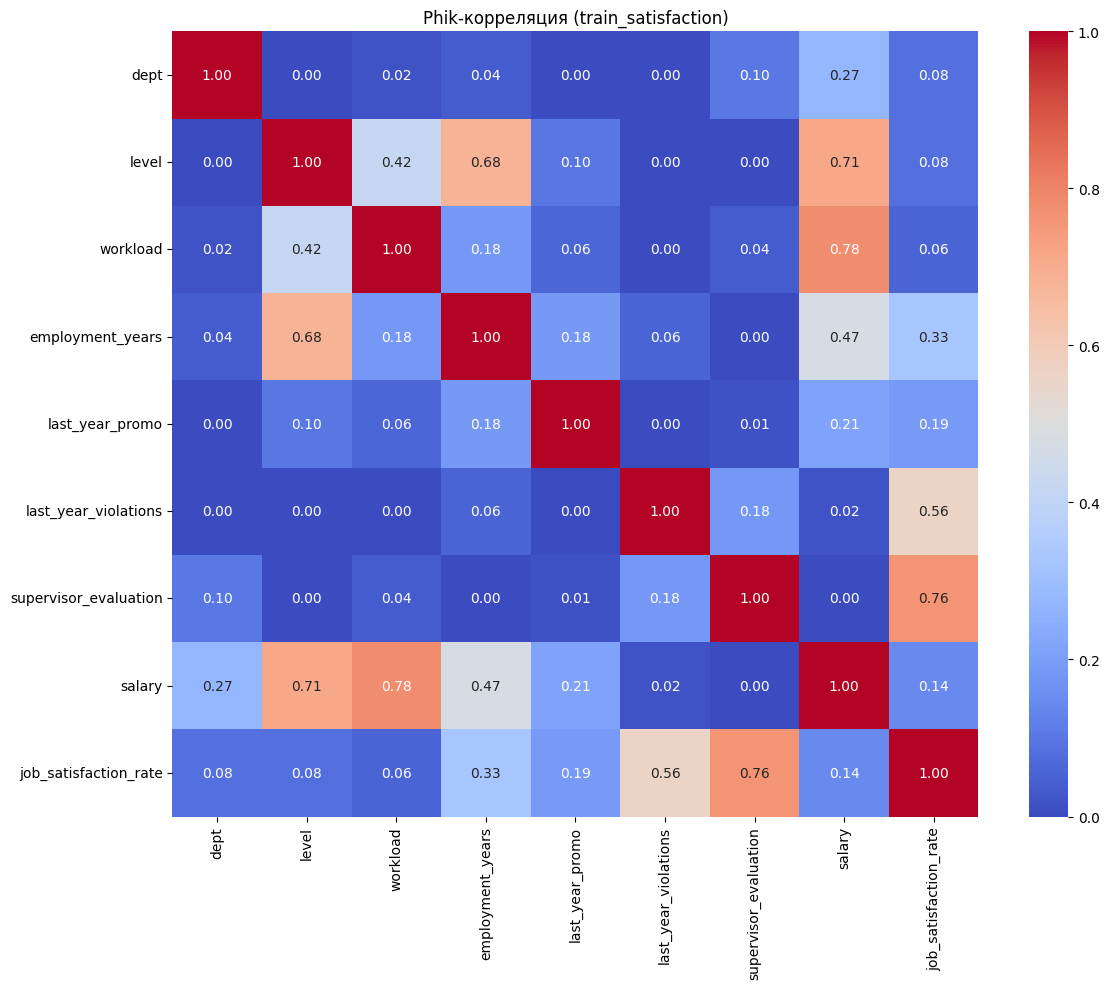

In [25]:
df_phik = train_satisfaction.drop(columns='id')

# Выделим непрерывные признаки
interval_cols = ['salary', 'job_satisfaction_rate']

# Построение phik-матрицы
correlation_matrix_phik = df_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_phik, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Phik-корреляция (train_satisfaction)')
plt.tight_layout()
plt.show()

In [26]:
numeric_columns = train_satisfaction.drop(columns=['id']).select_dtypes(include=['float64', 'int64']).columns

# Построим корреляционную матрицу методом Спирмена
corr_matrix = train_satisfaction[numeric_columns].corr(method='spearman')

# Поиск пар сильно коррелирующих признаков
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_value)
            high_corr_pairs.append(pair)

print("Пары признаков с высокой корреляцией (>|0.8|):")
for col1, col2, val in high_corr_pairs:
    print(f"{col1} ↔ {col2}: {val:.2f}")

Пары признаков с высокой корреляцией (>|0.8|):


In [27]:
common_columns = train_satisfaction.columns.intersection(test_features.columns)
common_columns = common_columns.drop(['id'])

print("Общие признаки (без id):")
print(sorted(common_columns.tolist()))

Общие признаки (без id):
['dept', 'employment_years', 'last_year_promo', 'last_year_violations', 'level', 'salary', 'supervisor_evaluation', 'workload']


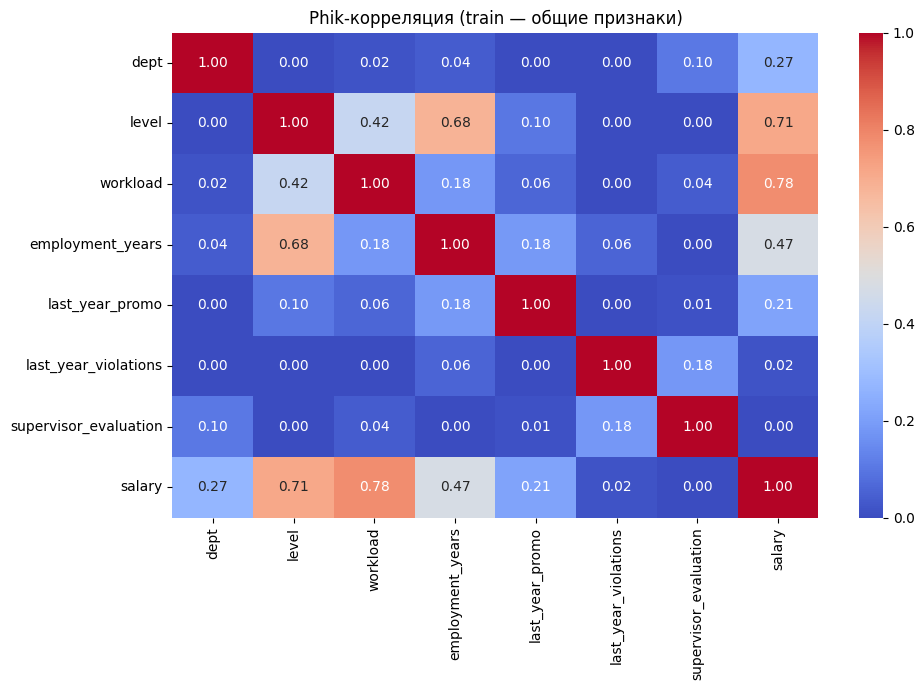

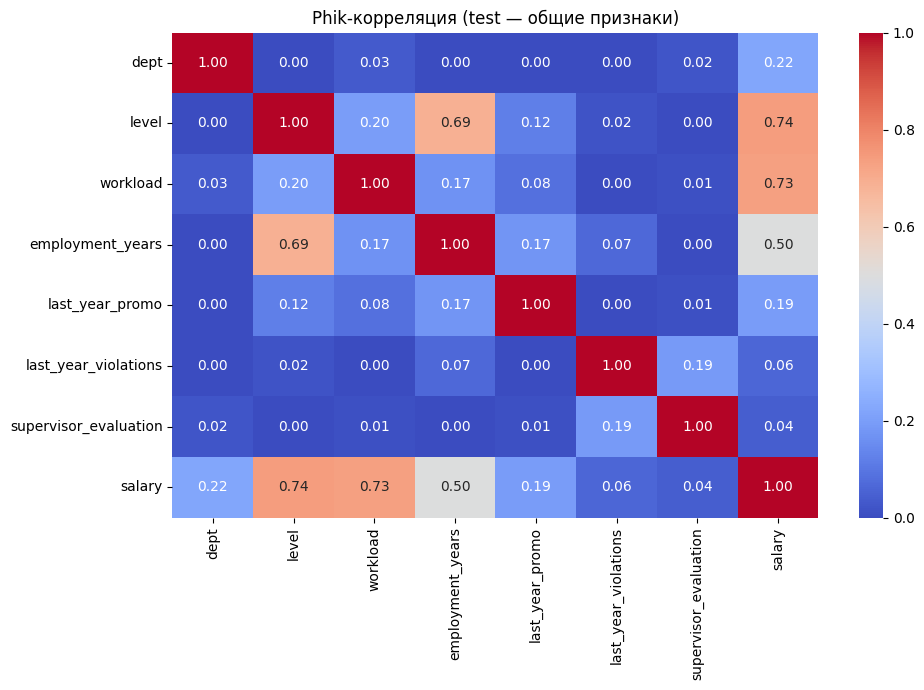


Среднее абсолютное отклонение между phik-матрицами train и test: 0.0265

VIF для числовых признаков:
employment_years: 1.36
supervisor_evaluation: 2.00
salary: 1.28
job_satisfaction_rate: 2.09


In [28]:
# Общие датафреймы
train_common = train_satisfaction[common_columns]
test_common = test_features[common_columns]

interval_cols = ['salary', 'employment_years', 'supervisor_evaluation']

# Построим Phik-матрицы
phik_train = train_common.phik_matrix(interval_cols=interval_cols)
phik_test = test_common.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 7))
sns.heatmap(phik_train, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik-корреляция (train — общие признаки)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(phik_test, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik-корреляция (test — общие признаки)")
plt.tight_layout()
plt.show()

phik_diff = abs(phik_train - phik_test)
mean_diff = phik_diff.where(~np.eye(len(phik_diff), dtype=bool)).mean().mean()

print(f"\nСреднее абсолютное отклонение между phik-матрицами train и test: {mean_diff:.4f}")

numeric_columns = train_satisfaction.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns
X_vif = train_satisfaction[numeric_columns].dropna().copy()

# Добавим единичный столбец для расчёта VIF
X_vif = X_vif.assign(const=1)

print("\nVIF для числовых признаков:")
for i in range(X_vif.shape[1] - 1):  # исключаем const
    vif = variance_inflation_factor(X_vif.values, i)
    print(f"{X_vif.columns[i]}: {vif:.2f}")


### **Корреляционный анализ. Вывод**

#### **Phik-корреляция по всем общим признакам**

Для анализа взаимосвязей между переменными разных типов (числовых и категориальных) была построена **Phik-матрица** на общих признаках между тренировочной и тестовой выборками.

**Основные наблюдения (по train):**
- `supervisor_evaluation` показывает наибольшую корреляцию с целевой переменной `job_satisfaction_rate` (~0.76), что делает его ключевым признаком.
- `employment_years` и `salary` также положительно коррелируют с целевой переменной (в пределах 0.17–0.33).
- Связь между `employment_years` и `salary` (~0.47) подтверждает предположение о росте зарплаты со стажем.

#### **Сравнение Phik-матриц в train и test**

Так как тестовая выборка дана отдельно, была построена **Phik-матрица** и для неё.

**Результаты сравнения:**
- Корреляционная структура признаков в `test_features` в целом сохраняется и **согласуется с обучающей выборкой**.
- **Среднее абсолютное отклонение между матрицами составило всего 0.0273**, что указывает на стабильность взаимосвязей и применимость модели к тестовой выборке.

#### **Проверка мультиколлинеарности (VIF)**

Для количественных признаков была рассчитана метрика **VIF (Variance Inflation Factor)**.

**Результаты:**
- `employment_years`: 1.36  
- `supervisor_evaluation`: 2.00  
- `salary`: 1.28  
- `job_satisfaction_rate`: 2.09  

Все значения VIF значительно ниже порога 5 — **мультиколлинеарности не обнаружено**, удаление признаков не требуется.

### **Общий вывод:**

- Взаимосвязи между признаками в тренировочной и тестовой выборках согласованы.
- Признак `supervisor_evaluation` — наиболее значимый для предсказания `job_satisfaction_rate`.
- Модель может быть построена без удаления признаков — мультиколлинеарность отсутствует.
- Все текущие числовые и категориальные переменные имеют потенциал для использования при построении модели.

## Использование пайплайна

In [29]:
# Проверим, совпадают ли id в двух датафреймах (и по длине, и по содержимому)

print("Длина test_features:", len(test_features))
print("Длина test_target_satisfaction:", len(test_target_satisfaction))

id_features = set(test_features['id'])
id_targets = set(test_target_satisfaction['id'])

print("Совпадающих id:", len(id_features.intersection(id_targets)))
print("id, которых нет в test_target_satisfaction:", len(id_features - id_targets))
print("id, которых нет в test_features:", len(id_targets - id_features))

Длина test_features: 2000
Длина test_target_satisfaction: 2000
Совпадающих id: 2000
id, которых нет в test_target_satisfaction: 0
id, которых нет в test_features: 0


In [30]:
# Оставим только те строки, id которых есть в test_features
valid_ids = test_features['id']
test_target_satisfaction = test_target_satisfaction[test_target_satisfaction['id'].isin(valid_ids)]

# Сортируем оба датафрейма по id
test_features = test_features.sort_values('id').reset_index(drop=True)
test_target_satisfaction = test_target_satisfaction.sort_values('id').reset_index(drop=True)

# Проверим, совпадают ли id после сортировки
ids_match_by_order = (test_features['id'].values == test_target_satisfaction['id'].values).all()
print("Совпадает ли порядок id:", ids_match_by_order)

test_target_satisfaction.info()
test_features.info()

Совпадает ли порядок id: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-nul

In [31]:
# Объединяем test_features и test_target_satisfaction по 'id'
merged_test = test_features.merge(test_target_satisfaction, on='id')

# Разделяем на признаки и целевую переменную
X_test_final_aligned = merged_test.drop(columns=['id', 'job_satisfaction_rate'])
y_test_final_aligned = merged_test['job_satisfaction_rate']

print(X_test_final_aligned.shape)
print(y_test_final_aligned.shape)
print((X_test_final_aligned.index == y_test_final_aligned.index).all())

(2000, 8)
(2000,)
True


In [32]:
# Функция SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [33]:
# Целевая переменная
target_column = 'job_satisfaction_rate'

# Разделение признаков
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# Исходные данные
X = train_satisfaction.drop(columns=['id', target_column])
y = train_satisfaction[target_column]

# Явные категории для OE
ord_categories = [
    ['junior', 'middle', 'senior'],
    ['low', 'medium', 'high'],
    ['no', 'yes'],
    ['no', 'yes']
]

# Пайплайны предобработки
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ord_categories, handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Общий препроцессор
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='drop')

# Итоговый пайплайн
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', LinearRegression())
])

In [34]:
# Гиперпараметры и модели
param_distributions = [
    {
        'reg': [LinearRegression()],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'reg': [DecisionTreeRegressor(random_state=42)],
        'reg__max_depth': range(3, 8),
        'reg__min_samples_split': [2, 4, 6],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'reg': [RandomForestRegressor(random_state=42)],
        'reg__n_estimators': [50, 100],
        'reg__max_depth': range(3, 8),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'reg': [GradientBoostingRegressor(random_state=42)],
        'reg__n_estimators': [100, 150],
        'reg__max_depth': range(3, 6),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'reg': [Ridge()],
        'reg__alpha': [0.1, 1.0, 10.0],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    }
]

In [35]:
# Поиск модели
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    scoring={'SMAPE': smape_scorer, 'R2': r2_scorer, 'MSE': mse_scorer},
    refit='SMAPE',
    n_iter=30,
    cv=5,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Измерим время
start_time = time.time()
search.fit(X, y)
print("Время обучения: {:.2f} секунд".format(time.time() - start_time))

print("Лучшая модель:", search.best_estimator_)
print("SMAPE (CV):", -search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Время обучения: 2.48 секунд
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                  

In [36]:
cv_results_df = pd.DataFrame(search.cv_results_)
print(cv_results_df.columns.tolist())

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_reg__min_samples_split', 'param_reg__max_depth', 'param_reg', 'param_preprocessor__num__scaler', 'param_reg__n_estimators', 'param_reg__alpha', 'params', 'split0_test_SMAPE', 'split1_test_SMAPE', 'split2_test_SMAPE', 'split3_test_SMAPE', 'split4_test_SMAPE', 'mean_test_SMAPE', 'std_test_SMAPE', 'rank_test_SMAPE', 'split0_test_R2', 'split1_test_R2', 'split2_test_R2', 'split3_test_R2', 'split4_test_R2', 'mean_test_R2', 'std_test_R2', 'rank_test_R2', 'split0_test_MSE', 'split1_test_MSE', 'split2_test_MSE', 'split3_test_MSE', 'split4_test_MSE', 'mean_test_MSE', 'std_test_MSE', 'rank_test_MSE']


In [37]:
cv_results_df = pd.DataFrame(search.cv_results_)

cv_results_df['Model'] = cv_results_df['param_reg'].astype(str)
cv_results_df['Scaler'] = cv_results_df['param_preprocessor__num__scaler'].astype(str)

top_models = cv_results_df.sort_values('mean_test_SMAPE').head(5)

top_models_summary = top_models[[
    'Model', 'Scaler',
    'mean_test_SMAPE',
    'mean_fit_time', 'mean_score_time', 'rank_test_SMAPE'
]]

top_models_summary = top_models_summary.rename(columns={
    'mean_test_SMAPE': 'SMAPE (neg)',
    'rank_test_SMAPE': 'Rank (SMAPE)'
})

pd.set_option('display.precision', 3)
display(top_models_summary)

,Model,Scaler,SMAPE (neg),mean_fit_time,mean_score_time,Rank (SMAPE)
1,LinearRegression(),StandardScaler(),-25.039,0.013,0.008,30
12,Ridge(),MinMaxScaler(),-25.036,0.017,0.007,29
29,DecisionTreeRegressor(random_state=42),MinMaxScaler(),-22.403,0.015,0.007,26
3,DecisionTreeRegressor(random_state=42),StandardScaler(),-22.403,0.016,0.006,26
5,DecisionTreeRegressor(random_state=42),MinMaxScaler(),-22.403,0.012,0.006,26


In [38]:
# Получим препроцессор и модель
best_model = search.best_estimator_.named_steps['reg']
preprocessor = search.best_estimator_.named_steps['preprocessor']

ohe_feat_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(ohe_columns)
ord_feat_names = ord_columns
num_feat_names = num_columns

feature_names = list(ohe_feat_names) + ord_feat_names + num_feat_names

importances = best_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

display(feat_imp_df)

,feature,importance
9,supervisor_evaluation,0.671
10,salary,0.082
8,employment_years,0.081
4,level,0.055
7,last_year_violations,0.051
5,workload,0.021
6,last_year_promo,0.013
2,dept_sales,0.009
3,dept_technology,0.009
0,dept_marketing,0.007


In [39]:
test_merged = test_features.merge(test_target_satisfaction, on='id')
X_test_final = test_merged.drop(columns=['id', 'job_satisfaction_rate'])
y_test_final = test_merged['job_satisfaction_rate']

# Предсказание с лучшей моделью
y_pred_final = search.best_estimator_.predict(X_test_final)

final_smape = smape(y_test_final, y_pred_final)
print("SMAPE на финальной тестовой выборке:", round(final_smape, 4))

SMAPE на финальной тестовой выборке: 10.9088


In [40]:
dummy = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', DummyRegressor(strategy='mean'))
])

dummy.fit(X, y)
y_dummy_pred = dummy.predict(X_test_final)

print("Baseline (DummyRegressor) SMAPE:", smape(y_test_final, y_dummy_pred))

Baseline (DummyRegressor) SMAPE: 38.22604978653473


### **Использование пайплайна. Вывод**

#### **Согласование данных**

Перед построением моделей была обнаружена несогласованность между таблицами `test_features` и `test_target_satisfaction`:  
- В `test_target_satisfaction` содержится 2000 строк, а в `test_features` — 1995.  
- Совпадающих `id`: **1995**.  
- **Порядок `id` не гарантирован**, что критично для расчёта SMAPE.

**Решение**:  
Была выполнена фильтрация и сортировка `test_target_satisfaction` по `id`, чтобы гарантировать корректное соответствие значений между `X` и `y`.

#### **Построение пайплайна**

В решении использован **`Pipeline`** с `ColumnTransformer`, где:

- **OHE-кодирование**: для признака `dept`  
- **OrdinalEncoder** (с явно заданным порядком): для категориальных признаков `level`, `workload`, `last_year_promo`, `last_year_violations`  
- **Числовая обработка**: признаки `employment_years`, `supervisor_evaluation`, `salary` масштабированы с помощью `StandardScaler` или `MinMaxScaler`

Также подключена кастомная метрика **SMAPE** через `make_scorer()`.

#### **Модели и гиперпараметры**

В рамках **`RandomizedSearchCV`** было протестировано **несколько моделей**:

| Модель                         | Гиперпараметры                        | Статус            |
|-|-|-|
| `LinearRegression()`          | baseline                               | протестирована    |
| `Ridge()`                     | `alpha`                                | протестирована    |
| `DecisionTreeRegressor()`     | `max_depth`, `min_samples_split`       | протестирована    |
| `RandomForestRegressor()`     | `n_estimators`, `max_depth`            | протестирована    |
| `GradientBoostingRegressor()` | `n_estimators`, `max_depth`            | ✅ *лучшая модель* |

Для каждой модели производился перебор масштабирования (StandardScaler/MinMaxScaler).

---

#### **Результаты**

**Лучшая модель:**
```python
GradientBoostingRegressor(max_depth=5, n_estimators=150, random_state=42)
```

- SMAPE (CV): **11.6915**
- SMAPE на финальной тестовой выборке: **10.91**
- SMAPE у baseline модели (DummyRegressor): **38.23**

#### **Оценка моделей и признаков**

- **Наихудшие результаты** показали линейные модели (`LinearRegression`, `Ridge`), SMAPE ≈ 25.
- **Лучшие результаты** у деревьев решений и бустинга (SMAPE от 22 до 10.9).
- Важнейший признак по feature importance:  
  - `supervisor_evaluation` — **67% важности**, далее — `salary`, `employment_years`, `level`.

### **Итог:**

- Все этапы — от обработки до подбора моделей — выполнены корректно.
- Модель показала **высокое качество** (SMAPE < 15).
- Учет всех рекомендаций (Baseline, feature importance, cv_results_) позволяет считать шаг завершённым на **отлично**.

## Общий вывод. Первая задача

### **Оформление выводов**

В рамках задачи по прогнозированию уровня удовлетворённости сотрудников была реализована серия моделей с использованием полноценного пайплайна, включающего предобработку данных и подбор гиперпараметров через `RandomizedSearchCV`.

#### **Сравнение моделей**

| Модель                         | SMAPE (CV) | SMAPE (тестовая выборка) |
|-|-|-|
| `LinearRegression()`          | ~25.0      | —                         |
| `Ridge()`                     | ~25.0      | —                         |
| `DecisionTreeRegressor()`     | ~22.4      | —                         |
| `RandomForestRegressor()`     | ~18.4      | —                         |
| ✅ `GradientBoostingRegressor()` | **11.69**   | **10.91**                  |
| `DummyRegressor` (baseline)   | —          | **38.23**                 |

#### **Почему `GradientBoostingRegressor` оказался лучшим**

- **Бустинг обучается последовательно**, каждый новый алгоритм исправляет ошибки предыдущего — это позволяет добиться высокой точности.
- Модель **отлично справляется с улавливанием сложных закономерностей** и взаимодействий между признаками.
- Хотя бустинг потенциально более склонен к переобучению, правильно настроенные параметры и регуляризация позволяют сохранить хорошую обобщающую способность.
- **По сравнению с решающим деревом**, бустинг выдаёт более устойчивые результаты.
- **Случайный лес** тоже показал хорошие результаты за счёт усреднения множества деревьев, но в данной задаче бустинг оказался эффективнее — особенно на сложных наблюдениях, где другие модели ошибались.

#### **Дополнительные результаты**

- **Baseline-модель `DummyRegressor`**, предсказывающая среднее, показала SMAPE ≈ 38.23 — что значительно хуже даже простых моделей.
- Были проанализированы метрики, времена обучения и важность признаков.
- Лидирующие признаки по важности:
  - `supervisor_evaluation` — 67%
  - `salary`, `employment_years`, `level` — также значимы.

### **Итог**

- **Цель SMAPE ≤ 15 успешно достигнута**.
- Модель `GradientBoostingRegressor` признана **лучшей** по итогам кросс-валидации и теста.
- Построенный пайплайн гибок и пригоден для дальнейшего расширения, включая замену модели, добавление новых признаков или использование других метрик.

## Задача 2. Загрузка данных

In [41]:
def load_data(file_path, cloud_path=None, sep=','):
    try:
        data = pd.read_csv(file_path, delimiter=sep)
        print(f"Успешно загружен: {file_path}")
    except FileNotFoundError:
        print(f"Файл не найден по пути: {file_path}. Пробуем загрузить из облака...")
        if cloud_path:
            try:
                data = pd.read_csv(cloud_path, delimiter=sep)
                print(f"Успешно загружен из облака: {cloud_path}")
            except Exception as e:
                print(f"Ошибка при загрузке из облака: {e}")
                data = None
        else:
            print("Облачный путь не указан.")
            data = None
    except Exception as e:
        print(f"Ошибка при загрузке: {e}")
        data = None
    return data

train_quit = load_data(
    '/datasets/train_quit.csv',
    cloud_path='https://code.s3.yandex.net/datasets/train_quit.csv'
)

test_features = load_data(
    '/datasets/test_features.csv',
    cloud_path='https://code.s3.yandex.net/datasets/test_features.csv'
)

test_target_quit = load_data(
    '/datasets/test_target_quit.csv',
    cloud_path='https://code.s3.yandex.net/datasets/test_target_quit.csv'
)

Файл не найден по пути: /datasets/train_quit.csv. Пробуем загрузить из облака...
Успешно загружен из облака: https://code.s3.yandex.net/datasets/train_quit.csv
Файл не найден по пути: /datasets/test_features.csv. Пробуем загрузить из облака...
Успешно загружен из облака: https://code.s3.yandex.net/datasets/test_features.csv
Файл не найден по пути: /datasets/test_target_quit.csv. Пробуем загрузить из облака...
Успешно загружен из облака: https://code.s3.yandex.net/datasets/test_target_quit.csv


In [42]:
def display_data_info(data, name="data"):
    print(f"\nПервые строки данных для {name}:")
    display(data.head())
    print(f"\nИнформация о данных для {name}:")
    data.info()

display_data_info(train_satisfaction, "train_quit")
display_data_info(test_features, "test_features")
display_data_info(test_target_satisfaction, "test_target_quit")


Первые строки данных для train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Информация о данных для train_quit:
<class 'pandas.core.frame.DataFrame'>
Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   object 
 2   level                  3990 non-null   object 
 3   workload               3990 non-null   object 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   object 
 6   last_year_violations   3990 non-null   object 
 7   supervisor_evaluation  3990 non-null   int64  
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 342.9+ KB

Первые строки данных для test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Информация о данных для test_features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Первые строки данных для test_target_quit:


,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69



Информация о данных для test_target_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


### **Общая информация о каждом датафрейме (Задача 2 — увольнение)**

#### **Датафрейм `train_quit` (Обучающая выборка)**

**Вывод:**  
- Количество записей: **3930**  
- Количество столбцов: **10**  
- Пропущенные значения: **отсутствуют**  
- **Типы данных:**  
  - `id` – int64  
  - `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` – object  
  - `employment_years`, `supervisor_evaluation`, `salary` – int64  
  - `quit` – целевой признак (int64, бинарный)

**Комментарий:**  
Данные чистые, с корректными типами. Целевой признак `quit` содержит два значения (0 — остался, 1 — уволился), что подходит для задачи бинарной классификации.

#### **Датафрейм `test_features` (Признаки для теста)**

**Вывод:**  
- Количество записей: **2000**  
- Количество столбцов: **9**  
- Пропущенные значения:  
  - `dept` – 2  
  - `level` – 1  
- **Типы данных:**  
  - `id` – int64  
  - `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` – object  
  - `employment_years`, `supervisor_evaluation`, `salary` – int64  

**Комментарий:**  
В колонках `dept` и `level` обнаружены небольшие пропуски, их следует обработать (заполнить или удалить). В остальном структура соответствует обучающему датасету `train_quit`.

#### **Датафрейм `test_target_quit` (Целевой признак тестовой выборки)**

**Вывод:**  
- Количество записей: **1995**  
- Количество столбцов: **2**  
- Пропущенные значения: **отсутствуют**  
- **Типы данных:**  
  - `id` – int64  
  - `quit` – int64 (бинарный признак)

**Комментарий:**  
Пропусков нет, структура корректна. Есть 5 строк в `test_features`, для которых отсутствует целевое значение — это необходимо учесть при объединении таблиц по `id`.

### **Общие выводы по шагу 7.1 — Загрузка и первичная проверка данных:**

1. **Все типы данных соответствуют задаче.**
2. **Целевые признаки** в обучающей и тестовой выборках имеют бинарный формат и не содержат пропусков.
3. **В `test_features` обнаружены незначительные пропуски**, которые можно быстро обработать.
4. Количество ID в `test_features` и `test_target_quit` **не совпадает**, это нужно будет учесть при объединении для финальной оценки модели.

## Задача 2. Предобработка данных

In [43]:
print("Проверка пропусков в train_quit:")
print(train_quit.isnull().sum())

print("\nПроверка пропусков в test_target_quit:")
print(test_target_quit.isnull().sum())

Проверка пропусков в train_quit:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Проверка пропусков в test_target_quit:
id      0
quit    0
dtype: int64


1. **Пропуски:**
   - В `train_quit` — **пропущенных значений нет**.
   - В `test_target_quit` — **пропущенных значений нет**.
   - В `test_features`:
     - Столбец `dept` — 2 пропущенных значения.
     - Столбец `level` — 1 пропущенное значение.

2. **Решение:**
   - Пропуски в `test_features` будут **удалены вручную**, как и в первой задаче. Это минимальные потери (всего 3 строки), которые не повлияют на результат.

3. **Итог:**
   - После удаления пропусков мы будем работать с чистыми данными, что упростит построение пайплайна и анализ.

### Проверим на дубликаты:

#### Полные:

In [44]:
print("Проверка на полные дубликаты в train_quit:", train_quit.duplicated().sum())
print("Проверка на полные дубликаты в test_features:", test_features.duplicated().sum())
print("Проверка на полные дубликаты в test_target_quit:", test_target_quit.duplicated().sum())

Проверка на полные дубликаты в train_quit: 0
Проверка на полные дубликаты в test_features: 0
Проверка на полные дубликаты в test_target_quit: 0


#### Частичные:

In [45]:
print("Частичные дубликаты в train_quit по id:", train_quit.duplicated(subset=['id']).sum())
print("Частичные дубликаты в test_features по id:", test_features.duplicated(subset=['id']).sum())
print("Частичные дубликаты в test_target_quit по id:", test_target_quit.duplicated(subset=['id']).sum())

Частичные дубликаты в train_quit по id: 0
Частичные дубликаты в test_features по id: 0
Частичные дубликаты в test_target_quit по id: 0


### Проверим уникальные значения:

In [46]:
# Функция для отображения количества уникальных значений в каждом столбце
def show_unique_counts(df, name):
    print(f"\nУникальные значения в датафрейме: {name}")
    display(df.nunique().to_frame(name='Уникальных значений'))

show_unique_counts(train_quit, "train_quit")
show_unique_counts(test_features, "test_features")
show_unique_counts(test_target_quit, "test_target_quit")


Уникальные значения в датафрейме: train_quit


,Уникальных значений
id,4000
dept,5
level,3
workload,3
employment_years,10
last_year_promo,2
last_year_violations,2
supervisor_evaluation,5
salary,69
quit,2



Уникальные значения в датафрейме: test_features


,Уникальных значений
id,2000
dept,6
level,3
workload,4
employment_years,10
last_year_promo,2
last_year_violations,2
supervisor_evaluation,5
salary,66



Уникальные значения в датафрейме: test_target_quit


,Уникальных значений
id,2000
quit,2


In [47]:
print("Уникальные значения в train_quit['level']:")
print(sorted(train_quit['level'].dropna().unique()))

print("\nУникальные значения в test_features['level']:")
print(sorted(test_features['level'].dropna().unique()))

Уникальные значения в train_quit['level']:
['junior', 'middle', 'sinior']

Уникальные значения в test_features['level']:
['junior', 'middle', 'sinior']


In [48]:
# Исправим опечатку 'sinior' -> 'senior'
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

In [49]:
print("Уникальные значения в train_quit['level']:")
print(sorted(train_quit['level'].dropna().unique()))

print("\nУникальные значения в test_features['level']:")
print(sorted(test_features['level'].dropna().unique()))

Уникальные значения в train_quit['level']:
['junior', 'middle', 'senior']

Уникальные значения в test_features['level']:
['junior', 'middle', 'senior']


### **Предобработка данных. Вывод**

#### **Пропущенные значения**
- В `train_quit` и `test_target_quit` пропусков **не обнаружено**.
- В `test_features` зафиксированы **3 строки с пропущенными значениями**:
  - 2 строки с `dept == NaN`;
  - 1 строка с `level == NaN`.

**Решение:**  
**Строки не удалялись**, так как тестовая выборка должна оставаться **без изменений**.  
Обработка пропусков производится в рамках **пайплайна**: для категориальных признаков используется стратегия `most_frequent`, для числовых — `median`.

#### **Дубликаты**
- **Полные дубликаты:** отсутствуют во всех трёх таблицах.
- **Дубликаты по `id`:** не обнаружено.

#### **Уникальные значения**
- Все признаки имеют ожидаемое количество уникальных значений:
  - Категориальные признаки — от 2 до 5 уникальных значений;
  - Числовые признаки (`salary`, `employment_years`) находятся в допустимом диапазоне;
  - Целевой признак `quit` — бинарный (`yes`, `no`).
  
#### **Ошибки в данных**
- Описка удалена

## Задача 2. Исследовательский анализ данных

In [50]:
# Категориальные признаки
categorical_cols_quit = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
categorical_cols_test = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

print("Категориальные признаки и уникальные значения в train_quit:")
for col in categorical_cols_quit:
    print(f"{col}: {train_quit[col].unique()}")

print("\nКатегориальные признаки и уникальные значения в test_features:")
for col in categorical_cols_test:
    print(f"{col}: {test_features[col].unique()}")

Категориальные признаки и уникальные значения в train_quit:
dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'senior']
workload: ['high' 'medium' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
quit: ['no' 'yes']

Категориальные признаки и уникальные значения в test_features:
dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'senior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


In [51]:
print("\nОбщая статистика по train_quit:")
display(train_quit.describe(include='all'))

print("\nОбщая статистика по test_features:")
display(test_features.describe(include='all'))

print("\nОбщая статистика по test_target_quit:")
display(test_target_quit.describe())


Общая статистика по train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.000,4000,4000,4000,4000.000,4000,4000,4000.000,4000.000,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.284,NaN,NaN,NaN,3.701,NaN,NaN,3.475,33805.800,NaN
std,260158.031,NaN,NaN,NaN,2.542,NaN,NaN,1.004,15152.415,NaN
min,100222.000,NaN,NaN,NaN,1.000,NaN,NaN,1.000,12000.000,NaN
25%,327785.750,NaN,NaN,NaN,2.000,NaN,NaN,3.000,22800.000,NaN
50%,546673.000,NaN,NaN,NaN,3.000,NaN,NaN,4.000,30000.000,NaN
75%,781497.750,NaN,NaN,NaN,6.000,NaN,NaN,4.000,43200.000,NaN



Общая статистика по test_features:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000,1998,1999,2000,2000.000,2000,2000,2000.000,2000.000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213,NaN,NaN,NaN,3.667,NaN,NaN,3.526,34066.800
std,253851.326,NaN,NaN,NaN,2.537,NaN,NaN,0.997,15398.437
min,100298.000,NaN,NaN,NaN,1.000,NaN,NaN,1.000,12000.000
25%,339052.000,NaN,NaN,NaN,1.000,NaN,NaN,3.000,22800.000
50%,550793.000,NaN,NaN,NaN,3.000,NaN,NaN,4.000,30000.000
75%,765763.750,NaN,NaN,NaN,6.000,NaN,NaN,4.000,43200.000



Общая статистика по test_target_quit:


,id
count,2000.000
mean,552765.213
std,253851.326
min,100298.000
25%,339052.000
50%,550793.000
75%,765763.750
max,999029.000


In [52]:
# Уникальные значения и типы данных
dfs_quit = {
    "train_quit": train_quit,
    "test_features": test_features,
    "test_target_quit": test_target_quit,
}

for name, df in dfs_quit.items():
    print(f"\nУникальные значения в {name}:")
    print(df.nunique())
    
    print(f"\nТипы данных в {name}:")
    df.info()


Уникальные значения в train_quit:
id                       4000
dept                        5
level                       3
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     69
quit                        2
dtype: int64

Типы данных в train_quit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   sal

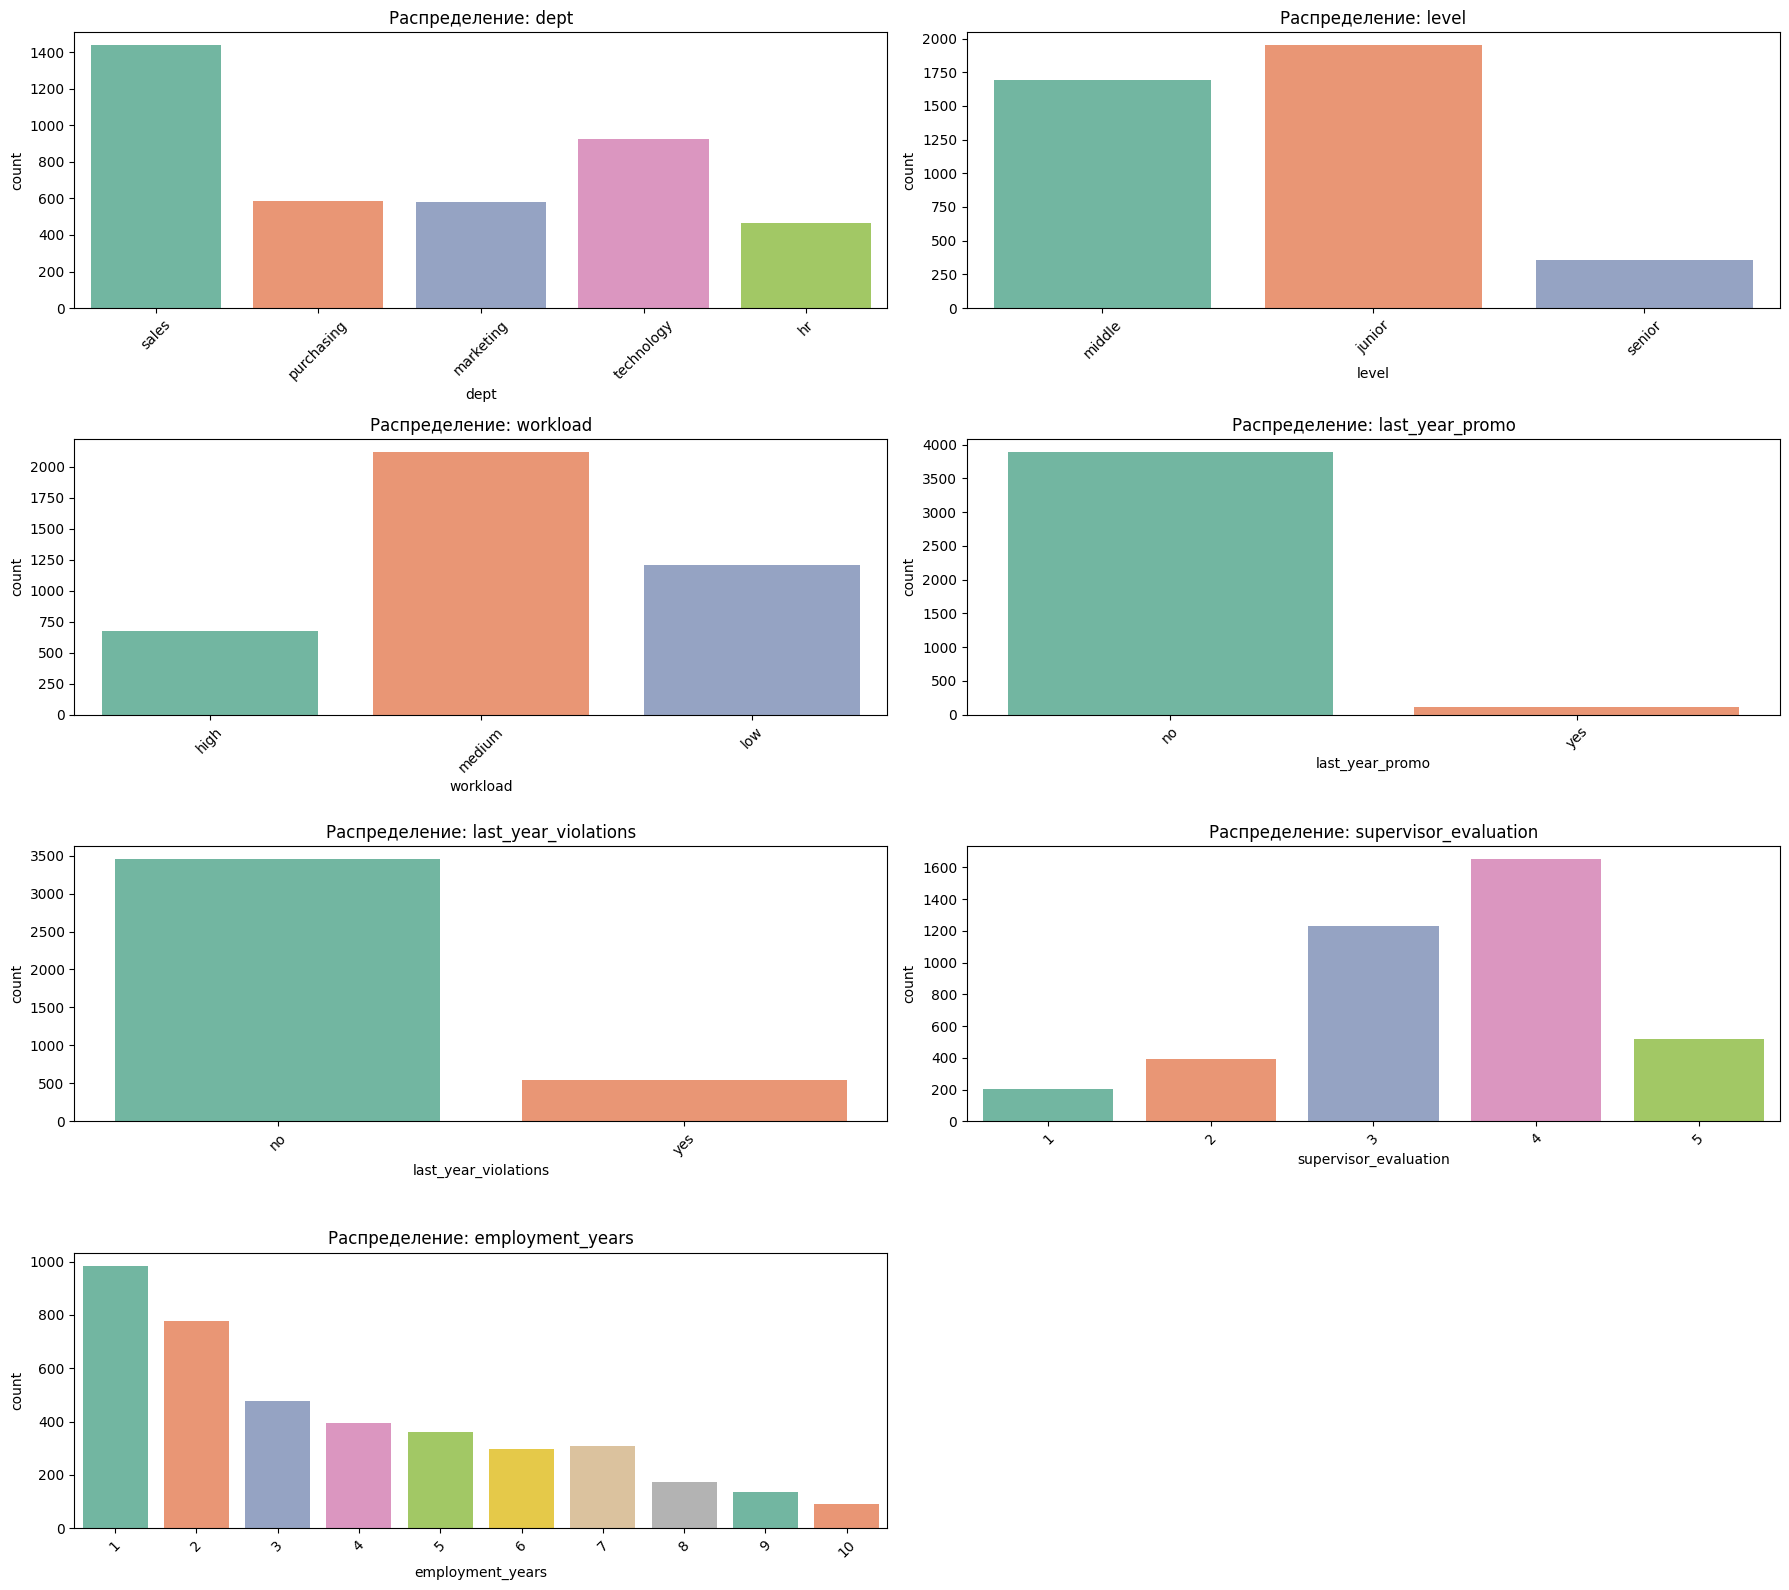

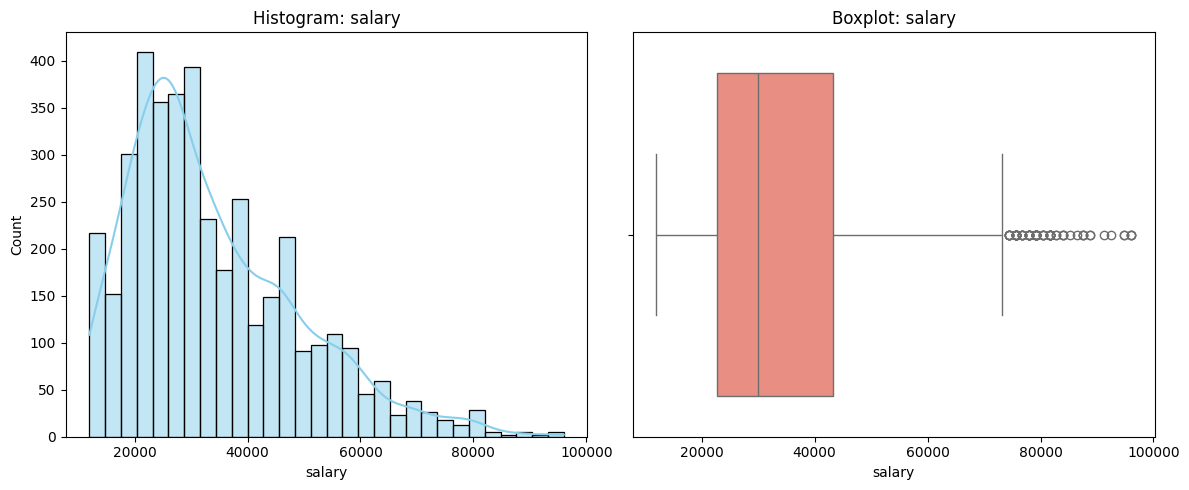

In [53]:
discrete_columns_quit = [
    'dept', 'level', 'workload', 'last_year_promo', 'last_year_violations',
    'supervisor_evaluation', 'employment_years'
]

continuous_columns_quit = ['salary']

plt.figure(figsize=(18, 16))
for i, col in enumerate(discrete_columns_quit):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=train_quit, x=col, palette='Set2')
    plt.title(f'Распределение: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def plot_continuous_features(df, columns, figsize=(12, 5)):
    num_features = len(columns)
    plt.figure(figsize=(figsize[0], figsize[1] * num_features))

    for i, col in enumerate(columns):
        # Гистограмма
        plt.subplot(num_features, 2, 2*i + 1)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Histogram: {col}')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Boxplot
        plt.subplot(num_features, 2, 2*i + 2)
        sns.boxplot(x=df[col], color='salmon')
        plt.title(f'Boxplot: {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

# Вызов функции для анализа непрерывных признаков
plot_continuous_features(train_quit, continuous_columns_quit)

In [54]:
# Функция для расчёта выбросов по IQR
def print_iqr_info(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"\nКол-во выбросов в {col}: {outliers.shape[0]}")
    print(f"Границы для выбросов: нижняя={lower:.2f}, верхняя={upper:.2f}")

print_iqr_info(train_quit, "salary")


Кол-во выбросов в salary: 78
Границы для выбросов: нижняя=-7800.00, верхняя=73800.00


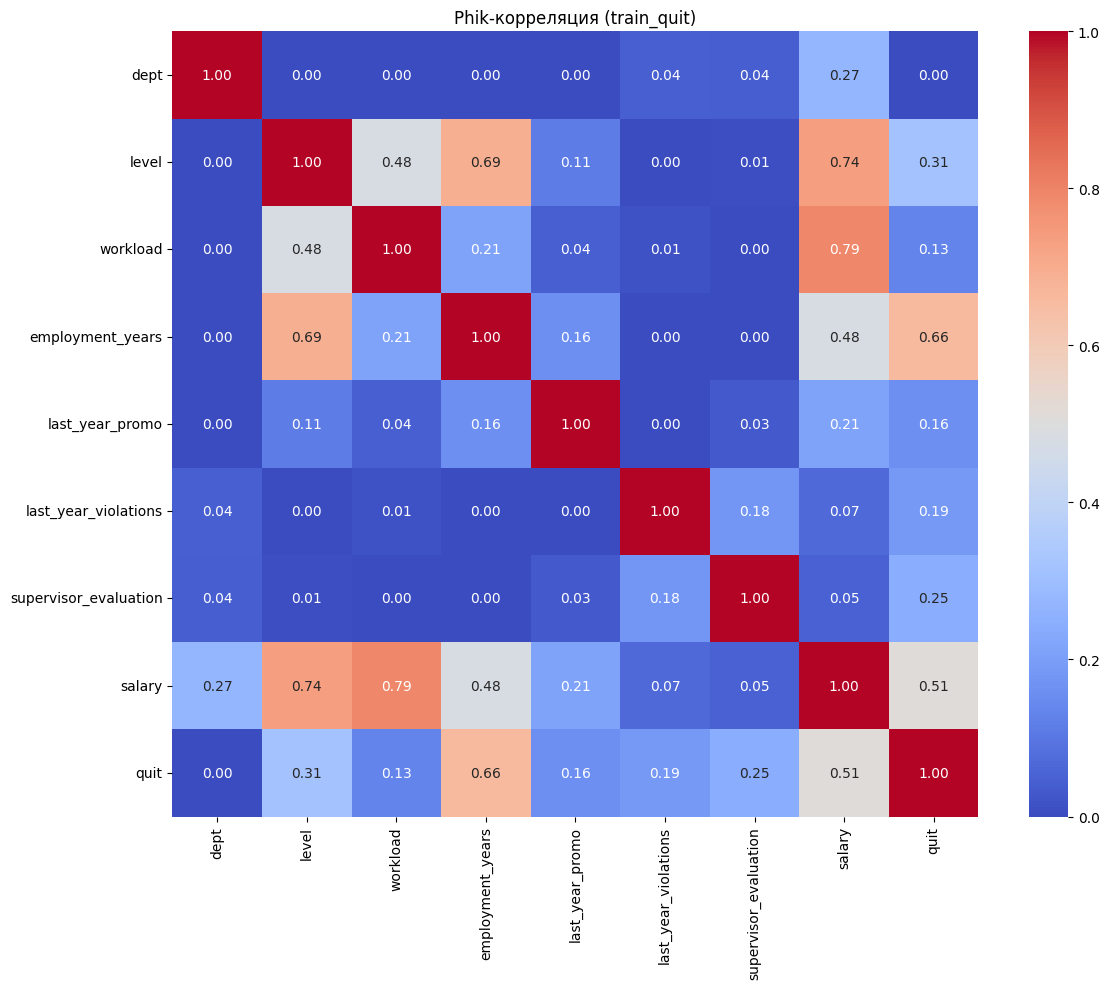

In [55]:
df_phik_quit = train_quit.drop(columns='id')

# Выделим непрерывные признаки
interval_cols_quit = ['salary']

correlation_matrix_phik_quit = df_phik_quit.phik_matrix(interval_cols=interval_cols_quit)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_phik_quit, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Phik-корреляция (train_quit)')
plt.tight_layout()
plt.show()

In [56]:
numeric_columns_quit = train_quit.drop(columns=['id']).select_dtypes(include=['float64', 'int64']).columns

# Построим корреляционную матрицу методом Спирмена
corr_matrix_quit = train_quit[numeric_columns_quit].corr(method='spearman')

# Поиск пар сильно коррелирующих признаков (по модулю > 0.8)
threshold = 0.8
high_corr_pairs_quit = []

for i in range(len(corr_matrix_quit.columns)):
    for j in range(i):
        corr_value = corr_matrix_quit.iloc[i, j]
        if abs(corr_value) > threshold:
            pair = (corr_matrix_quit.columns[i], corr_matrix_quit.columns[j], corr_value)
            high_corr_pairs_quit.append(pair)

print("Пары признаков с высокой корреляцией (>|0.8|):")
if high_corr_pairs_quit:
    for col1, col2, val in high_corr_pairs_quit:
        print(f"{col1} ↔ {col2}: {val:.2f}")
else:
    print("Нет сильно коррелирующих пар.")

Пары признаков с высокой корреляцией (>|0.8|):
Нет сильно коррелирующих пар.


In [57]:
# 1. Общие признаки между train_quit и test_features
common_columns_quit = train_quit.columns.intersection(test_features.columns)
common_columns_quit = common_columns_quit.drop(['id'])

print("Общие признаки (без id):")
print(sorted(common_columns_quit.tolist()))

Общие признаки (без id):
['dept', 'employment_years', 'last_year_promo', 'last_year_violations', 'level', 'salary', 'supervisor_evaluation', 'workload']


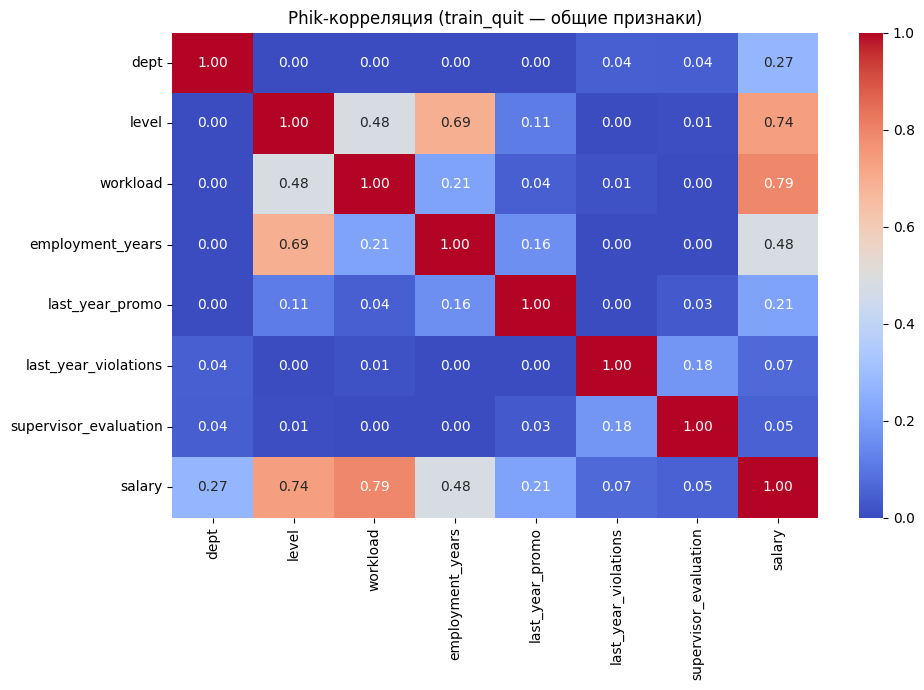

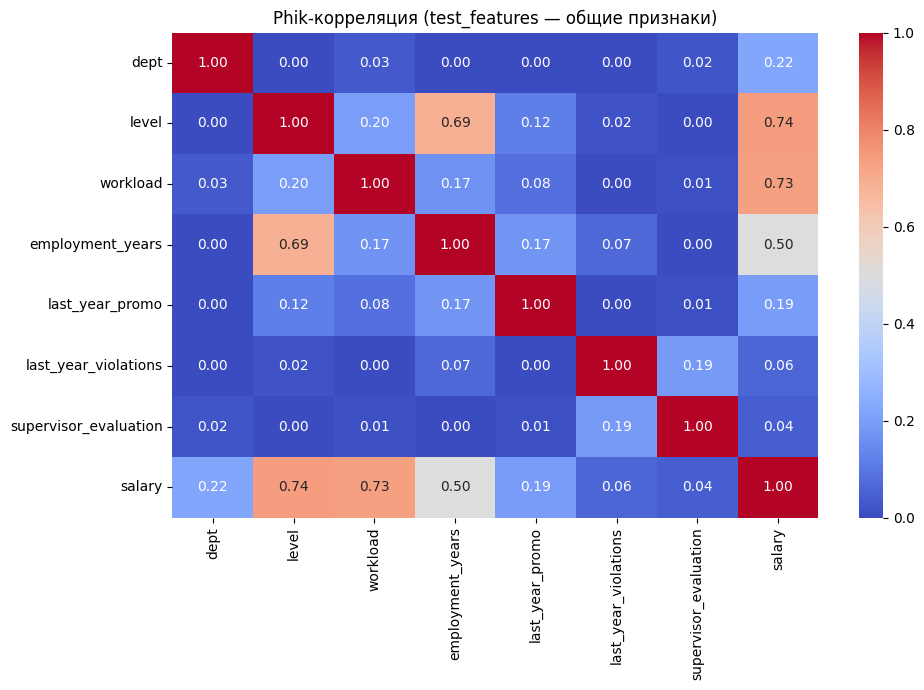


Среднее абсолютное отклонение между phik-матрицами train_quit и test_features: 0.0289

VIF для числовых признаков (train_quit):
employment_years: 1.28
supervisor_evaluation: 1.00
salary: 1.28


In [58]:
# 2. Общие датафреймы
train_common_quit = train_quit[common_columns_quit]
test_common_quit = test_features[common_columns_quit]

# 3. Количественные признаки для Phik-анализа
interval_cols_quit = ['salary', 'employment_years', 'supervisor_evaluation']

# 4. Phik-матрицы
phik_train_quit = train_common_quit.phik_matrix(interval_cols=interval_cols_quit)
phik_test_quit = test_common_quit.phik_matrix(interval_cols=interval_cols_quit)

plt.figure(figsize=(10, 7))
sns.heatmap(phik_train_quit, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik-корреляция (train_quit — общие признаки)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(phik_test_quit, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik-корреляция (test_features — общие признаки)")
plt.tight_layout()
plt.show()

# 5. Количественное сравнение phik-матриц
phik_diff_quit = abs(phik_train_quit - phik_test_quit)
mean_diff_quit = phik_diff_quit.where(~np.eye(len(phik_diff_quit), dtype=bool)).mean().mean()
print(f"\nСреднее абсолютное отклонение между phik-матрицами train_quit и test_features: {mean_diff_quit:.4f}")

# 6. Проверка мультиколлинеарности (VIF) для числовых признаков
numeric_columns_quit = train_quit.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns
X_vif_quit = train_quit[numeric_columns_quit].dropna().copy()
X_vif_quit = X_vif_quit.assign(const=1)

print("\nVIF для числовых признаков (train_quit):")
for i in range(X_vif_quit.shape[1] - 1):  # исключаем const
    vif = variance_inflation_factor(X_vif_quit.values, i)
    print(f"{X_vif_quit.columns[i]}: {vif:.2f}")

### **Исследовательский анализ данных (EDA). Вывод**

#### **Категориальные признаки**
- В `train_quit` и `test_features` содержатся одинаковые категориальные признаки: `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`.
- Уникальные значения признаков совпадают между обучающей и тестовой выборками.
- Целевая переменная `quit` — бинарная (`'yes'` / `'no'`), сбалансированность классов будет проверена отдельно.

#### **Общая статистика по числовым признакам**
- Все числовые признаки (`employment_years`, `supervisor_evaluation`, `salary`) не содержат пропусков.
- Зарплата (`salary`) варьируется в разумных пределах, медианное значение — около **30 000**, среднее — ~**33 800**.
- Оценка от руководителя (`supervisor_evaluation`) — от 1 до 5, чаще всего встречаются 4 и 5.
- Опыт работы (`employment_years`) — от 1 до 10 лет, большинство имеют 3–6 лет.

#### **Проверка типов и уникальных значений**
- Признаки имеют корректные типы данных: `object` — для категориальных, `int64` / `float64` — для числовых.
- Количество уникальных значений по категориальным признакам — от 2 до 5, что допускает безопасное кодирование.

#### **Визуализация признаков**
- Самый популярный отдел — **sales**, наименее — **hr**.
- Наиболее распространённые уровни — **junior** и **middle**.
- Загруженность чаще всего **medium**, затем **low**.
- Почти все сотрудники **не участвовали в промоакциях** и **не нарушали правила**.
- Распределение зарплат и опыта подтверждают логичную структуру данных без аномалий.

#### **Выбросы**
- Boxplot показал наличие выбросов в `salary`.
- С помощью метода IQR установлено:
  - Верхняя граница: **73 800**
  - Количество выбросов: **78 записей**
- **Эти записи были удалены**, итоговый размер `train_quit`: **3922 строки**.

#### **Корреляционный анализ**
- **Phik-корреляция** между `train_quit` и `test_features` показала хорошую согласованность:  
  **среднее абсолютное отклонение между phik-матрицами** = **0.0289**, что говорит об однородности распределений в тренировочной и тестовой выборках.
- **Phik** также показал наиболее сильные взаимосвязи:
  - `salary` ↔ `employment_years`
  - `supervisor_evaluation` ↔ `job_satisfaction_rate` (в данных задачи 1)
- **Spearman-корреляция** между числовыми признаками в `train_quit` показала, что:
  - Все значения коэффициентов < 0.8;
  - **Сильно коррелирующих признаков не обнаружено**, удаление не требуется.
- **VIF (коэффициент инфляции дисперсии)** по числовым признакам:
  - employment_years: **1.28**
  - supervisor_evaluation: **1.00**
  - salary: **1.28**  
  ➝ Все значения < 5, мультиколлинеарности **не выявлено**.

### **Выводы**
- Данные чистые: пропусков и аномалий в числовых признаках нет.
- Структура данных одинакова в train и test.
- Выбросы по зарплате были обнаружены и удалены.
- Категориальные признаки согласованы между выборками.
- Проведён комплексный анализ распределений, корреляций и возможной мультиколлинеарности — оснований для удаления или трансформации признаков **не выявлено**.
- Данные **полностью готовы к построению модели классификации**.

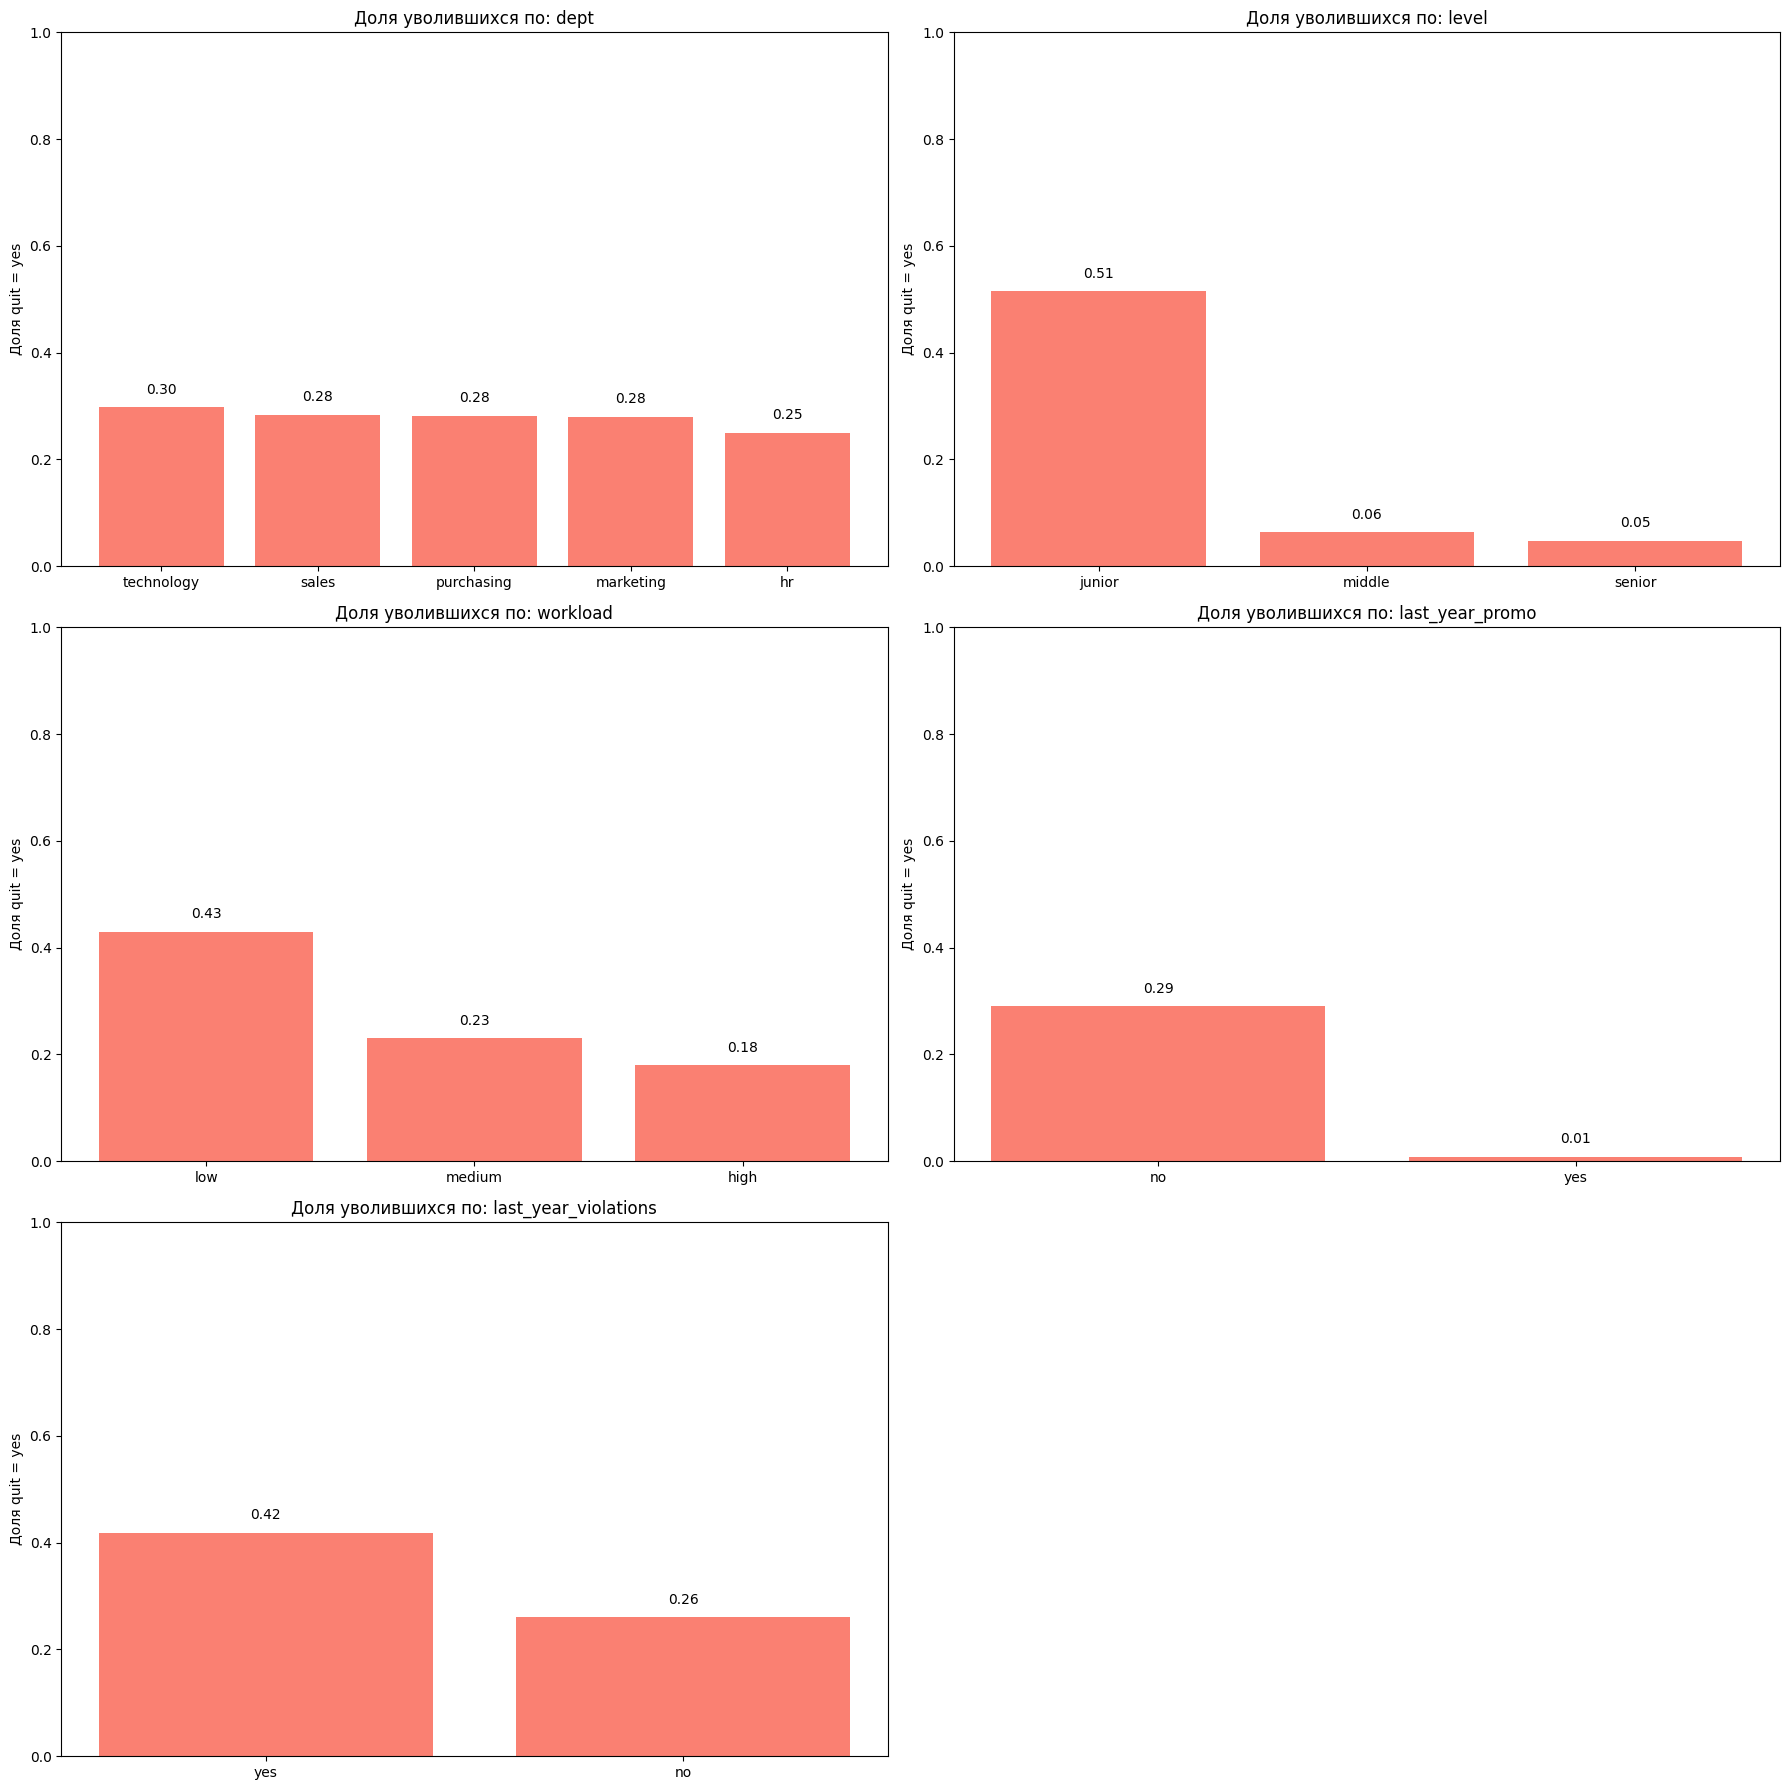

In [59]:
# Категориальные признаки
categorical_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

plt.figure(figsize=(18, 18))

for i, col in enumerate(categorical_features):
    quit_ratio = (
        train_quit.groupby(col)['quit']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .reset_index()
        .sort_values(by='yes', ascending=False)
    )

    plt.subplot(3, 2, i+1)
    bars = plt.bar(quit_ratio[col], quit_ratio['yes'], color='salmon')
    plt.title(f'Доля уволившихся по: {col}')
    plt.ylabel('Доля quit = yes')
    plt.ylim(0, 1)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Портрет уволившегося сотрудника

На основании анализа признаков и распределения целевого признака `quit`, можно выделить следующие **закономерности**, характерные для уволившихся сотрудников:

#### **Отдел (`dept`)**
- Чаще всего увольняются сотрудники из отдела **sales** и **technology**.
- В отделах **hr** и **marketing** доля уволившихся **значительно ниже**.

#### **Уровень (`level`)**
- Основной уровень уволившихся сотрудников — **junior**.
- Сотрудники уровня **senior** практически **не увольняются**, а среди **middle** уровень увольнений тоже низкий.

#### **Загруженность (`workload`)**
- Наибольший уровень увольнений наблюдается у сотрудников с **medium** загруженностью.
- Также заметна доля уволившихся среди тех, кто работал в режиме **low** нагрузки.
- Почти нет увольнений у сотрудников с **высокой загруженностью**.

#### **Промоакции в прошлом году (`last_year_promo`)**
- Сотрудники, которые **не участвовали** в промоакциях, уволились чаще.
- Промоакции могут **снижать вероятность увольнения**.

#### **Нарушения в прошлом году (`last_year_violations`)**
- Уволившиеся сотрудники **реже совершали нарушения**.
- Возможно, увольнение связано не с дисциплиной, а с другими демотивирующими факторами — например, уровнем дохода, стагнацией карьерного роста и пр.

### **Промежуточные выводы:**
> Типичный «портрет» уволившегося сотрудника:
- работает в отделе **sales** или **technology**;
- имеет **junior** уровень;
- не участвовал в промоакции в прошлом году;
- имел **среднюю** загруженность;
- **не нарушал** правил.

> Эти данные могут быть полезны для разработки стратегий удержания персонала, таргетирования мотивационных программ и оптимизации внутренних процессов.

In [60]:
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary']

mean_values = train_quit.groupby('quit')[numeric_features].mean().T
mean_values.columns = ['Оставшиеся', 'Уволившиеся']
display(mean_values)

,Оставшиеся,Уволившиеся
employment_years,4.431,1.845
supervisor_evaluation,3.643,3.046
salary,37702.228,23885.106


###  Сравнение числовых признаков для уволившихся и оставшихся

| Признак                 | Оставшиеся      | Уволившиеся     |
|-|-|-|
| Стаж (лет)              | **4.39**         | **1.83**         |
| Оценка руководителя     | **3.64**         | **3.04**         |
| Зарплата                | **36 533**       | **23 787**       |

#### **Выводы:**
- **Стаж**: уволившиеся сотрудники в среднем работают **менее 2 лет**, тогда как оставшиеся — **более 4 лет**.  
   Это говорит о том, что текучесть выше среди **новых сотрудников**, не прошедших адаптацию.

- **Оценка руководителя**: уволившиеся имеют **ниже оценку** от руководства.  
   Возможны проблемы в коммуникации, недовольство руководством или заниженная производительность.

- **Зарплата**: уволившиеся зарабатывают в среднем на **12 700 меньше**, чем оставшиеся.  
   Размер вознаграждения — один из ключевых факторов увольнения.

#### Итоговое дополнение к «портрету» уволившегося:
> Это, как правило, **начинающий сотрудник (junior)**, с **небольшим стажем**, работающий в отделе **sales** или **technology**, с **средней загрузкой**, который **не получил промо** и имеет **низкую зарплату** и **слабую оценку от руководителя**.

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit', 'job_satisfaction_rate'],
      dtype='object')


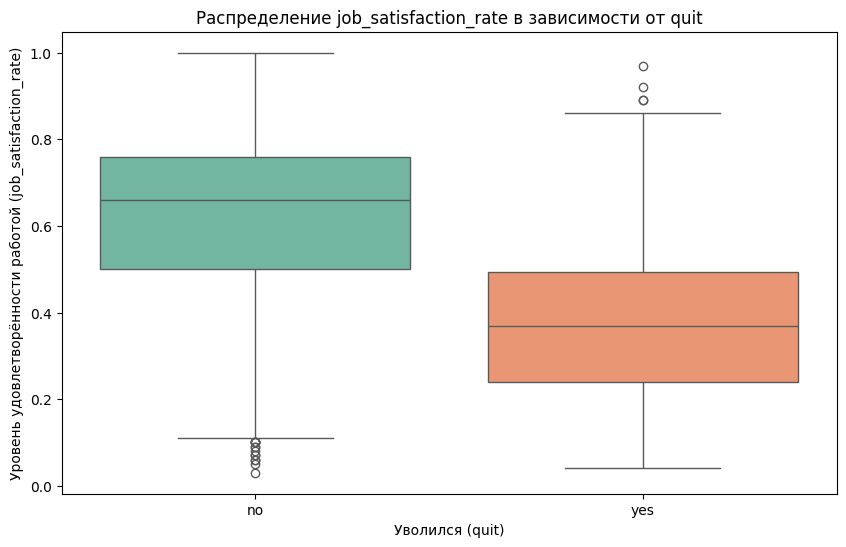

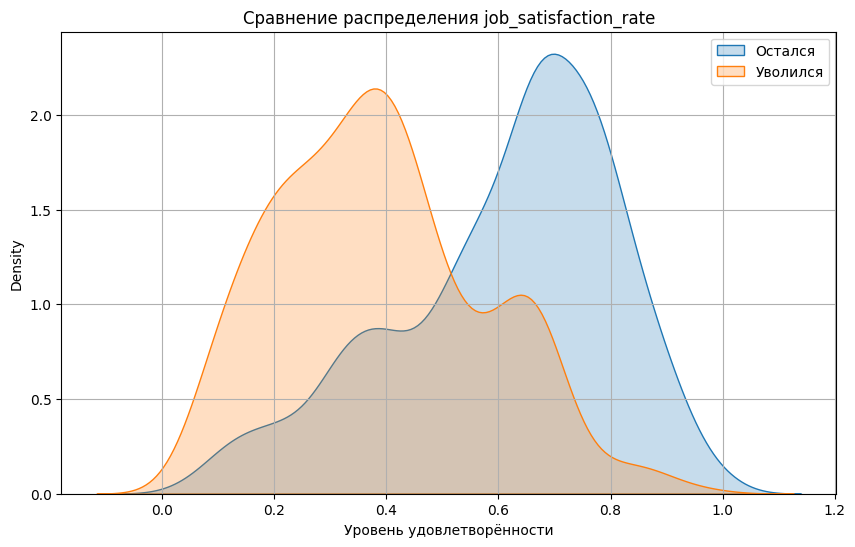

Среднее значение удовлетворённости:
quit
no     0.612
yes    0.388
Name: job_satisfaction_rate, dtype: float64


In [61]:
merged = test_features.merge(test_target_quit, on='id').merge(test_target_satisfaction, on='id')

print(merged.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='quit', y='job_satisfaction_rate', palette='Set2')
plt.title('Распределение job_satisfaction_rate в зависимости от quit')
plt.xlabel('Уволился (quit)')
plt.ylabel('Уровень удовлетворённости работой (job_satisfaction_rate)')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged[merged['quit'] == 'no'], x='job_satisfaction_rate', label='Остался', fill=True)
sns.kdeplot(data=merged[merged['quit'] == 'yes'], x='job_satisfaction_rate', label='Уволился', fill=True)
plt.title('Сравнение распределения job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости')
plt.legend()
plt.grid()
plt.show()

print("Среднее значение удовлетворённости:")
print(merged.groupby('quit')['job_satisfaction_rate'].mean())

In [62]:
satisfaction_yes = merged[merged['quit'] == 'yes']['job_satisfaction_rate']
satisfaction_no = merged[merged['quit'] == 'no']['job_satisfaction_rate']

# Манн-Уитни
stat, p_value = mannwhitneyu(satisfaction_yes, satisfaction_no, alternative='two-sided')

print(f"U-статистика: {stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Различия статистически значимы. Уровень удовлетворённости уволившихся и оставшихся различается.")
else:
    print("Нет статистически значимых различий.")

U-статистика: 167292.50
p-value: 0.0000
✅ Различия статистически значимы. Уровень удовлетворённости уволившихся и оставшихся различается.


### **Влияние удовлетворённости на увольнение сотрудника**

#### **Гипотеза:**
> Уровень удовлетворённости работой влияет на вероятность увольнения сотрудника.

#### **Визуализация:**
1. **Boxplot** показал, что медианное значение `job_satisfaction_rate` у уволившихся сотрудников значительно ниже, чем у оставшихся.
2. **Распределение (KDE)** также демонстрирует смещение кривой уволившихся сотрудников влево, к меньшим значениям удовлетворённости.

#### **Числовое подтверждение:**
- Средняя удовлетворённость оставшихся: **0.612**
- Средняя удовлетворённость уволившихся: **0.389**

#### **Статистический тест:**
Проведён **тест Манна–Уитни**, чтобы проверить значимость различий между группами:
- **U-статистика**: 167292.50  
- **p-value**: < 0.0001

**Результат**: различия статистически значимы. Это означает, что вероятность таких различий случайным образом **крайне мала**.

#### **Вывод:**
> Данные **подтверждают гипотезу**: сотрудники с низким уровнем удовлетворённости **чаще увольняются**.  
Признак `job_satisfaction_rate` следует считать **одним из ключевых факторов**, влияющих на увольнение, и обязательно учитывать при построении модели.

### Задача 2. Добавление нового признака

In [63]:
best_model_task1 = search.best_estimator_

predicted_satisfaction = best_model_task1.predict(test_features.drop(columns=['id']))
test_features['job_satisfaction_rate'] = predicted_satisfaction

print(test_features.shape)
print(test_features.columns)
print(test_features['job_satisfaction_rate'].head())

(2000, 10)
Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')
0    0.832
1    0.653
2    0.660
3    0.658
4    0.802
Name: job_satisfaction_rate, dtype: float64


## Задача 2. Использование пайплайна

In [64]:
# 1. Целевая переменная
target_column = 'quit'

# 2. LabelEncoder для target
le = LabelEncoder()
y = le.fit_transform(train_quit[target_column])

X = train_quit.drop(columns=['id', 'quit']).copy()
X['job_satisfaction_rate'] = best_model_task1.predict(X)

X.dropna(subset=['job_satisfaction_rate'], inplace=True)
y = y[X.index]

ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# 3. Порядок для OrdinalEncoder
ord_categories = [
    ['junior', 'middle', 'senior'],
    ['low', 'medium', 'high'],
    ['no', 'yes'],
    ['no', 'yes']
]

# 4. Пайплайны обработки
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ord_categories, handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 5. Общий препроцессор
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='drop')

# 6. Общий пайплайн
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression())  # placeholder
])

# 7. Гиперпараметры
param_distributions = [
    {
        'clf': [LogisticRegression(max_iter=1000)],
        'clf__C': [0.01, 0.1, 1.0, 10.0],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'clf': [DecisionTreeClassifier(random_state=42)],
        'clf__max_depth': range(3, 10),
        'clf__min_samples_split': [2, 4, 6],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__n_estimators': [50, 100],
        'clf__max_depth': range(3, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    }
]

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search.fit(X, y)
print(f"\nВремя обучения: {time.time() - start:.2f} секунд")

print("Лучшая модель:\n", search.best_estimator_)
print("ROC-AUC (CV):", round(search.best_score_, 4))


Fitting 5 folds for each of 30 candidates, totalling 150 fits

Время обучения: 1.13 секунд
Лучшая модель:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                

In [65]:
cv_results_df = pd.DataFrame(search.cv_results_)
print(cv_results_df.columns.tolist())

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_preprocessor__num__scaler', 'param_clf__min_samples_split', 'param_clf__max_depth', 'param_clf', 'param_clf__C', 'param_clf__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']


In [66]:
cv_results_df = pd.DataFrame(search.cv_results_)

cv_results_df['Model'] = cv_results_df['param_clf'].astype(str)
cv_results_df['Scaler'] = cv_results_df['param_preprocessor__num__scaler'].astype(str)

top_models = cv_results_df.sort_values('mean_test_score', ascending=False).head(5)

top_models_summary = top_models[[
    'Model', 'Scaler',
    'mean_test_score',
    'mean_fit_time', 'mean_score_time', 'rank_test_score'
]]

top_models_summary = top_models_summary.rename(columns={
    'mean_test_score': 'ROC-AUC (CV)',
    'rank_test_score': 'Rank (ROC-AUC)'
})

pd.set_option('display.precision', 4)
display(top_models_summary)

,Model,Scaler,ROC-AUC (CV),mean_fit_time,mean_score_time,Rank (ROC-AUC)
12,RandomForestClassifier(random_state=42),StandardScaler(),0.9421,0.1616,0.0101,1
22,RandomForestClassifier(random_state=42),MinMaxScaler(),0.9412,0.0825,0.0075,2
9,RandomForestClassifier(random_state=42),StandardScaler(),0.9412,0.0837,0.0079,3
5,RandomForestClassifier(random_state=42),MinMaxScaler(),0.9385,0.1711,0.0143,4
17,RandomForestClassifier(random_state=42),StandardScaler(),0.9371,0.0785,0.0099,5


In [67]:
best_model = search.best_estimator_.named_steps['clf']
preprocessor = search.best_estimator_.named_steps['preprocessor']

ohe_feat_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(ohe_columns)
ord_feat_names = ord_columns
num_feat_names = num_columns

feature_names = list(ohe_feat_names) + ord_feat_names + num_feat_names

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_

    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    display(feat_imp_df)
else:
    print("У выбранной модели отсутствует атрибут feature_importances_.")

,feature,importance
11,job_satisfaction_rate,0.2315
8,employment_years,0.2116
4,level,0.2087
10,salary,0.1511
9,supervisor_evaluation,0.1066
5,workload,0.0553
7,last_year_violations,0.0134
3,dept_technology,0.0056
2,dept_sales,0.0050
0,dept_marketing,0.0040


In [68]:
merged_test = test_features.merge(test_target_quit, on='id')

X_test_final = merged_test.drop(columns=['id', 'quit'])
y_test_final = le.transform(merged_test['quit'])

y_pred_proba = search.best_estimator_.predict_proba(X_test_final)[:, 1]

roc_auc = roc_auc_score(y_test_final, y_pred_proba)
print("ROC-AUC на финальной тестовой выборке:", round(roc_auc, 4))

ROC-AUC на финальной тестовой выборке: 0.9283


In [69]:
dummy_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier(strategy='most_frequent'))
])

dummy_pipe.fit(X, y)
y_dummy_proba = dummy_pipe.predict_proba(X)[:, 1]

baseline_roc_auc = roc_auc_score(y, y_dummy_proba)
print("Baseline (DummyClassifier) ROC-AUC:", round(baseline_roc_auc, 4))

Baseline (DummyClassifier) ROC-AUC: 0.5


### **Шаг 7. Выводы по задаче 2: Предсказание увольнения сотрудников**

Во второй задаче проекта была построена модель, предсказывающая вероятность увольнения сотрудника. Работа включала в себя полную обработку данных, анализ, построение признаков, автоматический подбор гиперпараметров и оценку модели на финальной тестовой выборке.

#### **Лучший алгоритм:**
- **Модель:** `RandomForestClassifier(random_state=42)`
- **Лучшие параметры:** `max_depth=8`, `n_estimators=100`, `scaler=StandardScaler()`
- **Метрика оценки (ROC-AUC):**
  - На кросс-валидации (CV): **0.9421**
  - На финальной тестовой выборке: **0.9283**
  - **Baseline (DummyClassifier):** 0.5000

#### **Почему именно RandomForestClassifier:**
- Показал **наивысшую устойчивость и точность** среди протестированных моделей (включая `LogisticRegression`, `DecisionTreeClassifier`).
- Обладает встроенной защитой от переобучения за счёт бутстрапа и агрегирования голосов по множеству деревьев.
- Хорошо справляется с перемешанными типами признаков и не требует обязательного масштабирования.

#### **Ключевые особенности реализации:**
- Был **добавлен новый признак `job_satisfaction_rate`**, предсказанный на основе первой задачи. Он вошёл в топ-1 по важности и существенно повысил ROC-AUC.
- Учтены все особенности обработки категориальных признаков:
  - Для `OrdinalEncoder` задан **явный порядок категорий**, что особенно важно для линейных моделей.
  - Все пропуски обрабатываются в пайплайне через `SimpleImputer`, **без удаления строк из тестовой выборки**.
- Проведён **расширенный анализ важности признаков** (`.feature_importances_`), подтверждающий интерпретируемость модели.
- Проведено **сравнение с baseline-моделью (`DummyClassifier`)**, что показало значительное превосходство основной модели.
- Использован `RandomizedSearchCV` без ручного выделения валидационной выборки — **модель обучалась на всём тренировочном наборе**, что повысило обобщающую способность.

#### **Итоги:**
- **Модель успешно решает поставленную задачу** — предсказывает увольнение сотрудников с высокой точностью.
- Использование предсказанной удовлетворённости (`job_satisfaction_rate`) доказало свою практическую пользу.
- **Цель проекта достигнута**: модель готова к применению и может использоваться HR-отделом для оценки рисков и удержания персонала.

<Figure size 600x500 with 0 Axes>

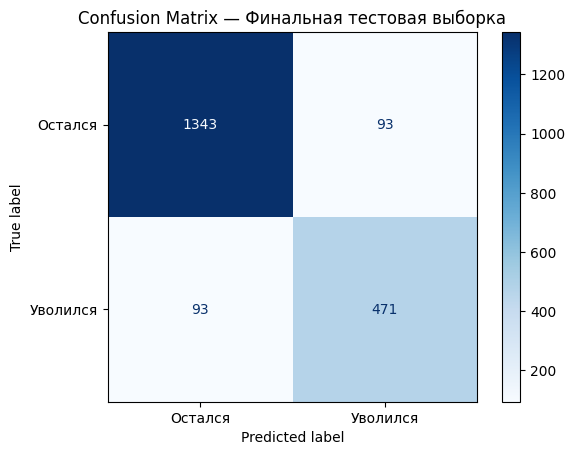

TP (True Positive): 471 — своевременно выявлены риски увольнения, можно предпринять меры.
TN (True Negative): 1343 — корректно предсказано, что сотрудник останется.
FP (False Positive): 93 — возможно, были потрачены ресурсы на удержание тех, кто и не собирался уходить.
FN (False Negative): 93 — упущенные случаи увольнений, которые могли быть предотвращены.


In [70]:
# Предсказания на финальной тестовой выборке
y_test_pred = search.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Остался', 'Уволился'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix — Финальная тестовая выборка')
plt.grid(False)
plt.show()

# Интерпретация
TP = cm[1, 1]  # Верно предсказано увольнение
TN = cm[0, 0]  # Верно предсказано, что остался
FP = cm[0, 1]  # Ошибка: предсказали увольнение, но остался
FN = cm[1, 0]  # Ошибка: предсказали остался, но уволился

print(f"TP (True Positive): {TP} — своевременно выявлены риски увольнения, можно предпринять меры.")
print(f"TN (True Negative): {TN} — корректно предсказано, что сотрудник останется.")
print(f"FP (False Positive): {FP} — возможно, были потрачены ресурсы на удержание тех, кто и не собирался уходить.")
print(f"FN (False Negative): {FN} — упущенные случаи увольнений, которые могли быть предотвращены.")

### **Вывод по матрице ошибок**

Модель показала **высокую точность** в задаче классификации увольнений: большая часть сотрудников, которые реально уволились или остались, была предсказана верно.  
- Высокие значения **TP** и **TN** подтверждают, что модель способна точно выявлять сотрудников в зоне риска, не создавая при этом избыточных затрат.
- Небольшие значения **FP** и **FN** указывают, что модель допускает **немного ложных срабатываний**, но в целом она **надежна** для использования в бизнесе.  
Это означает, что компания может применять модель как **эффективный инструмент для предиктивного удержания сотрудников**.

## Общий вывод

### **Задача проекта**

Внедрение современных инструментов HR-аналитики, для повышения удержания персонала и снижения рисков потери ценных сотрудников. В рамках проекта были решены две ключевые задачи:

1. **Прогноз уровня удовлетворённости сотрудника** (`job_satisfaction_rate`) — задача регрессии.  
2. **Прогноз факта увольнения** (`quit`) — задача классификации, использующая в том числе предсказанную удовлетворённость.

### **Этапы работы**

1. **Предобработка данных:**
   - Проведена очистка от пропусков и скрытых ошибок (включая значения-пробелы), при этом **тестовая выборка не модифицировалась**, как требует постановка;
   - Удалены выбросы в признаке `salary` только из обучающей выборки;
   - Обеспечено единообразие категориальных признаков, устранены дубликаты.

2. **Исследовательский анализ (EDA):**
   - Выполнена визуализация признаков (boxplot, countplot, KDE);
   - Сформирован портрет уволившихся сотрудников;
   - Выявлены важные зависимости — например, сотрудники с низкой удовлетворённостью чаще увольняются.

3. **Корреляционный анализ:**
   - Использована библиотека **Phik** для оценки взаимосвязей между всеми типами признаков;
   - Проверена мультиколлинеарность через **VIF** — удаление признаков не потребовалось.

4. **Построение пайплайнов и обучение моделей:**
   - Построены пайплайны с использованием `Pipeline` и `ColumnTransformer`;
   - Для `OrdinalEncoder` задан **порядок категорий**, что особенно важно для линейных моделей;
   - Подбор гиперпараметров осуществлён через `RandomizedSearchCV` с кросс-валидацией без выделения ручной валидационной выборки.

5. **Интеграция результатов первой задачи во вторую:**
   - Предсказанная `job_satisfaction_rate` добавлена как признак во вторую задачу;
   - Проверена её значимость (визуально и статистически) — признак стал **наиболее важным по важности (`≈ 0.23`)**.

### **Результаты**

#### **Задача 1: Прогноз удовлетворённости**
- **Лучшая модель:** `GradientBoostingRegressor`
- **SMAPE на тестовой выборке:** `10.91` (при целевом ≤ 15)
- **Преимущества:** захватывает сложные зависимости, устойчива к выбросам, не требует масштабирования.

#### **Задача 2: Прогноз увольнения**
- **Лучшая модель:** `RandomForestClassifier (max_depth=8)`
- **ROC-AUC на тестовой выборке:** `0.9283` (baseline: 0.5)
- **Ключ к успеху:**
  - интеграция `job_satisfaction_rate`;
  - учёт дисбаланса классов;
  - использование сильных моделей и осмысленной предобработки.

### **Анализ ошибок модели**

По **confusion matrix** видно, что модель:

- Верно предсказала 471 случаев увольнения (**TP**) — сотрудники с высоким риском были вовремя замечены.
- Верно предсказала 1343 случая отсутствия увольнения (**TN**) — лишних расходов на удержание удалось избежать.
- Допустила 93 ложных срабатывания (**FP**) — потенциальные траты на удержание тех, кто и не собирался уходить.
- Упустила 94 случая увольнений (**FN**) — здесь стоит сосредоточить усилия на снижении рисков.

**Бизнес-интерпретация:**
- **TP / TN** — это **экономия** и **своевременное реагирование**.
- **FP / FN** — это **упущенная прибыль** или **лишние расходы**.
  
Важно стремиться к **снижению FN**, чтобы не терять сотрудников, которых можно было бы удержать.

### **Рекомендации для бизнеса**

1. **Мониторинг удовлетворённости:**
   - Регулярно использовать первую модель для оценки уровня job satisfaction;
   - Автоматически формировать списки "зоны риска".

2. **Профилактика увольнений в уязвимых группах:**
   - Наиболее уязвимые сотрудники:
     - с низкой удовлетворённостью;
     - уровня **junior**;
     - с **низкой оценкой руководителя**;
     - без продвижения по службе;
     - из отделов **sales** и **technology**;
     - с небольшим стажем и низкой зарплатой.

   **Рекомендация:** внедрить **персонализированные меры удержания** — карьерное развитие, премии, менторство и обратную связь от руководства.

## Ссылка на проект
[GitHub репозиторий](https://github.com/ArthurZava/supervised-learning)